# 데이터 분석과 기계학습 code

201804225 이다진

주제 : 게임 데이터 순위 예측 분석 

- 분석 특징(1차 피드백에 대한 생각)

전략적 팀 전투의 경우, 8명의 사람이 개인전, 랜덤으로 자신 제외 7명과 만나 먼저 챔피언이 다 죽는 유저가 피가 일정량 깍이는 게임이므로 
누군가 한명을 지목해서 때리거나, 빨리 죽일 수 없다는 전제가 생김

또한 아이템의 지급 부분에 있어서 모든 아이템을 자기가 원하는 템을 먹지 못하고, 선택 할 수 있는 경우에도 점수가 낮은 사람부터 아이템을 선택할 수 있으므로 이는 충분히 8등 -> 1등을 할 수 있는 가능성이 열려있고 초중반 상위 등수가 꼭 4등안에 들어온다는 보장이 없음 

마지막으로 랜덤한 사람들끼리의 다른 시너지로 다른 아이템을 가지고 싸우기 때문에 '아이템 좋은 거주고', '별 높게 만들어서' '순위 낮은 애들을 빨리 죽여서' 등의 뻔한 결과가 오히려 어렵다고 생각함 

이를 통해 이번 프로젝트에서는 주요 key-point로

1. 랭크와 어떠한 요소가 제일 승률이 있는가? - level, chap_name, gameDuration, chap_len
2. level, chap_name, gameDuration, chap_len간의 상관성 
3. 4등이상/ 미만의 순위 예측 

을 주 분석하고 의미도출과 순위 예측 input/output 도출(의미 해석과 학습한 데이터가 실제로 맞는가)을 하려고 한다. 

________________________________________________________________________________________________________________________________________

1. 데이터 준비 및 전처리 

- 이번 2차 코드 특징으로는 master 유저들을 다 수집하지 않고 200명의 유저들의 데이터를 가지고 옴
- 원래의 원본 데이터의 경우 80000개의 유저 게임 데이터가 존재하지만, 최종적으로 분석 결과를 낼때에는 10000명으로 늘려서 할 것임 


In [1596]:
#기본적인 라이브러리 설치

In [1806]:
import pandas as pd 
import numpy as np
import json
from collections import defaultdict
import copy 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

In [1807]:
masterData = pd.read_csv('dataMachine/TFT_master_MatchData.csv')

In [1808]:
masterData

,gameId,gameDuration,level,lastRound,Ranked,ingameDuration,combination,champion
0,KR_4242528808,2233.449951,8,37,1,2225.243408,"{'DarkStar': 2, 'Protector': 4, 'Rebel': 1, 'S...","{'JarvanIV': {'items': [12], 'star': 3}, 'Sona..."
1,KR_4242528808,2233.449951,9,37,2,2225.243408,"{'Blaster': 2, 'Chrono': 1, 'Cybernetic': 1, '...","{'Malphite': {'items': [], 'star': 2}, 'Blitzc..."
2,KR_4242528808,2233.449951,8,35,3,2138.763428,"{'Blaster': 3, 'Chrono': 2, 'Cybernetic': 1, '...","{'Malphite': {'items': [], 'star': 2}, 'Blitzc..."
3,KR_4242528808,2233.449951,8,33,4,2003.865967,"{'Chrono': 2, 'Cybernetic': 2, 'DarkStar': 2, ...","{'Leona': {'items': [], 'star': 2}, 'Mordekais..."
4,KR_4242528808,2233.449951,7,31,5,1885.395386,"{'Blaster': 1, 'DarkStar': 1, 'Demolitionist':...","{'KhaZix': {'items': [], 'star': 2}, 'KaiSa': ..."
...,...,...,...,...,...,...,...,...
79994,KR_4367610629,2171.343994,8,35,4,1931.437500,"{'Chrono': 1, 'Cybernetic': 1, 'DarkStar': 2, ...","{'TwistedFate': {'items': [], 'star': 3}, 'Pop..."
79995,KR_4367610629,2171.343994,8,33,5,1815.786133,"{'Chrono': 1, 'DarkStar': 1, 'ManaReaver': 3, ...","{'Darius': {'items': [15, 39], 'star': 3}, 'Ra..."
79996,KR_4367610629,2171.343994,8,30,6,1658.850586,"{'Chrono': 2, 'Cybernetic': 1, 'DarkStar': 1, ...","{'TwistedFate': {'items': [], 'star': 2}, 'Mal..."
79997,KR_4367610629,2171.343994,7,28,7,1562.578125,"{'Protector': 4, 'Rebel': 3, 'Set3_Blademaster...","{'Yasuo': {'items': [78], 'star': 3}, 'Sona': ..."


In [1809]:
masterData = masterData[:200]

In [1810]:
# master 1-8 등 중 없는 데이터의 경우 err_game에 담기 
data_cons = masterData.groupby('gameId')['Ranked'].count().tolist()
err_game = []

for i in range(len(data_cons)):
    if data_cons[i] != 8:
        print(masterData.groupby('gameId')['Ranked'].count().keys()[i])
        err_game.append(masterData.groupby('gameId')['Ranked'].count().keys()[i])

In [1811]:
err_game

[]

In [1753]:
masterData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gameId          200 non-null    object 
 1   gameDuration    200 non-null    float64
 2   level           200 non-null    int64  
 3   lastRound       200 non-null    int64  
 4   Ranked          200 non-null    int64  
 5   ingameDuration  200 non-null    float64
 6   combination     200 non-null    object 
 7   champion        200 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 12.6+ KB


In [1812]:
comb_cols = []
for i in masterData.combination:
    col = list(json.loads(i.replace("'", "\"")).keys())
    for j in col: 
        if j not in comb_cols:
            comb_cols.append(j)

In [1755]:
len(comb_cols)

24

In [1756]:
comb_dic = defaultdict(int)
for i in comb_cols :
    comb_dic[i] = 0

In [1757]:
len(comb_dic)

24

In [1758]:
for i in range(len(masterData.combination)):
    dic = copy.deepcopy(comb_dic)
    col = json.loads(masterData.combination[i].replace("'", "\""))
    for k, v in zip(col.keys(), col.values()):
        dic[k] = v
    masterData.combination[i] = dic

<ipython-input-1758-e18a55050ade>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masterData.combination[i] = dic
C:\Users\dajin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [1759]:
len(dic)

24

In [1760]:
masterData.combination

0      {'DarkStar': 2, 'Protector': 4, 'Rebel': 1, 'S...
1      {'DarkStar': 0, 'Protector': 0, 'Rebel': 2, 'S...
2      {'DarkStar': 0, 'Protector': 0, 'Rebel': 3, 'S...
3      {'DarkStar': 2, 'Protector': 0, 'Rebel': 0, 'S...
4      {'DarkStar': 1, 'Protector': 0, 'Rebel': 0, 'S...
                             ...                        
195    {'DarkStar': 0, 'Protector': 0, 'Rebel': 0, 'S...
196    {'DarkStar': 1, 'Protector': 0, 'Rebel': 1, 'S...
197    {'DarkStar': 0, 'Protector': 0, 'Rebel': 0, 'S...
198    {'DarkStar': 0, 'Protector': 0, 'Rebel': 6, 'S...
199    {'DarkStar': 0, 'Protector': 0, 'Rebel': 2, 'S...
Name: combination, Length: 200, dtype: object

In [1761]:
len(comb_cols)

24

In [1762]:
len(masterData)

200

In [1763]:
count = 0
for i in comb_cols :
    for j in range(len(masterData)):
        masterData.loc[j,i] = masterData.loc[j, 'combination'][i]
        if(j %100 == 0 ):
            #print("success")
            count+=1

C:\Users\dajin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\dajin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [1764]:
count

48

In [1765]:
masterData.head(5)

,gameId,gameDuration,level,lastRound,Ranked,ingameDuration,combination,champion,DarkStar,Protector,...,Starship,Infiltrator,ManaReaver,Sniper,SpacePirate,Vanguard,Demolitionist,MechPilot,Set3_Sorcerer,TemplateTrait
0,KR_4242528808,2233.449951,8,37,1,2225.243408,"{'DarkStar': 2, 'Protector': 4, 'Rebel': 1, 'S...","{'JarvanIV': {'items': [12], 'star': 3}, 'Sona...",2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KR_4242528808,2233.449951,9,37,2,2225.243408,"{'DarkStar': 0, 'Protector': 0, 'Rebel': 2, 'S...","{'Malphite': {'items': [], 'star': 2}, 'Blitzc...",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KR_4242528808,2233.449951,8,35,3,2138.763428,"{'DarkStar': 0, 'Protector': 0, 'Rebel': 3, 'S...","{'Malphite': {'items': [], 'star': 2}, 'Blitzc...",0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KR_4242528808,2233.449951,8,33,4,2003.865967,"{'DarkStar': 2, 'Protector': 0, 'Rebel': 0, 'S...","{'Leona': {'items': [], 'star': 2}, 'Mordekais...",2.0,0.0,...,0.0,1.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,0.0
4,KR_4242528808,2233.449951,7,31,5,1885.395386,"{'DarkStar': 1, 'Protector': 0, 'Rebel': 0, 'S...","{'KhaZix': {'items': [], 'star': 2}, 'KaiSa': ...",1.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0


________________________________________________________________________________________________________________________________________

In [702]:
#champion name 과 item 분리하기 

In [717]:
#matser2로 따로 만들기 

In [1766]:
masterData2 = pd.read_csv('dataMachine/TFT_master_MatchData.csv')

In [1767]:
masterData2 = masterData[:200]

In [1768]:
masterData2.champion.values

array(["{'JarvanIV': {'items': [12], 'star': 3}, 'Sona': {'items': [46], 'star': 3}, 'Rakan': {'items': [37, 45], 'star': 3}, 'XinZhao': {'items': [25, 66, 13], 'star': 3}, 'Neeko': {'items': [], 'star': 2}, 'Karma': {'items': [], 'star': 2}, 'Soraka': {'items': [], 'star': 1}, 'Lulu': {'items': [99, 47, 55], 'star': 2}}",
       "{'Malphite': {'items': [], 'star': 2}, 'Blitzcrank': {'items': [], 'star': 2}, 'Vi': {'items': [], 'star': 1}, 'Jinx': {'items': [56, 13, 29], 'star': 2}, 'Soraka': {'items': [], 'star': 2}, 'ChoGath': {'items': [36, 6, 27], 'star': 2}, 'Kayle': {'items': [], 'star': 2}, 'MissFortune': {'items': [37, 34], 'star': 1}, 'Lulu': {'items': [17], 'star': 2}}",
       "{'Malphite': {'items': [], 'star': 2}, 'Blitzcrank': {'items': [], 'star': 2}, 'Ezreal': {'items': [], 'star': 2}, 'Vi': {'items': [36], 'star': 2}, 'Jinx': {'items': [13, 57, 69], 'star': 1}, 'ChoGath': {'items': [], 'star': 2}, 'MissFortune': {'items': [33, 69], 'star': 2}, 'AurelionSol': {'items': 

In [1769]:
a

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [1770]:
#inven = masterData.champion.get('items')
print(masterData.champion)

0      {'JarvanIV': {'items': [12], 'star': 3}, 'Sona...
1      {'Malphite': {'items': [], 'star': 2}, 'Blitzc...
2      {'Malphite': {'items': [], 'star': 2}, 'Blitzc...
3      {'Leona': {'items': [], 'star': 2}, 'Mordekais...
4      {'KhaZix': {'items': [], 'star': 2}, 'KaiSa': ...
                             ...                        
195    {'Zoe': {'items': [], 'star': 2}, 'Ahri': {'it...
196    {'Sona': {'items': [], 'star': 1}, 'Jayce': {'...
197    {'Xayah': {'items': [], 'star': 1}, 'Blitzcran...
198    {'Malphite': {'items': [25], 'star': 2}, 'Yasu...
199    {'Malphite': {'items': [], 'star': 2}, 'Graves...
Name: champion, Length: 200, dtype: object


In [1772]:
#champion

In [1773]:
champion_col = []
for d in masterData.champion:
    col = list(json.loads(d.replace("'", "\"")).keys())
    for j in col: 
        if j not in champion_col:
            champion_col.append(j)

In [1774]:
champion_col2 = []
for d in masterData2.champion:
    col = list(json.loads(d.replace("'", "\"")).values())
    champion_col2.append(col)

In [1775]:
champion_col2[0]

[{'items': [12], 'star': 3},
 {'items': [46], 'star': 3},
 {'items': [37, 45], 'star': 3},
 {'items': [25, 66, 13], 'star': 3},
 {'items': [], 'star': 2},
 {'items': [], 'star': 2},
 {'items': [], 'star': 1},
 {'items': [99, 47, 55], 'star': 2}]

In [1776]:
n = []
for i in range (len(champion_col2)): 
    #print(champion_col2[i])
    data = 0
    for j in range (len(champion_col2[i])):
        print(i,"번유저의 ",j,'번째 챔피언이 가지고 있는 아이템:', champion_col2[i][j].get('items'))
        data += (len((champion_col2[i][j].get('items'))))
    n.append(data)

print(n)

#champion_col2[0][1].get('items')

0 번유저의  0 번째 챔피언이 가지고 있는 아이템: [12]
0 번유저의  1 번째 챔피언이 가지고 있는 아이템: [46]
0 번유저의  2 번째 챔피언이 가지고 있는 아이템: [37, 45]
0 번유저의  3 번째 챔피언이 가지고 있는 아이템: [25, 66, 13]
0 번유저의  4 번째 챔피언이 가지고 있는 아이템: []
0 번유저의  5 번째 챔피언이 가지고 있는 아이템: []
0 번유저의  6 번째 챔피언이 가지고 있는 아이템: []
0 번유저의  7 번째 챔피언이 가지고 있는 아이템: [99, 47, 55]
1 번유저의  0 번째 챔피언이 가지고 있는 아이템: []
1 번유저의  1 번째 챔피언이 가지고 있는 아이템: []
1 번유저의  2 번째 챔피언이 가지고 있는 아이템: []
1 번유저의  3 번째 챔피언이 가지고 있는 아이템: [56, 13, 29]
1 번유저의  4 번째 챔피언이 가지고 있는 아이템: []
1 번유저의  5 번째 챔피언이 가지고 있는 아이템: [36, 6, 27]
1 번유저의  6 번째 챔피언이 가지고 있는 아이템: []
1 번유저의  7 번째 챔피언이 가지고 있는 아이템: [37, 34]
1 번유저의  8 번째 챔피언이 가지고 있는 아이템: [17]
2 번유저의  0 번째 챔피언이 가지고 있는 아이템: []
2 번유저의  1 번째 챔피언이 가지고 있는 아이템: []
2 번유저의  2 번째 챔피언이 가지고 있는 아이템: []
2 번유저의  3 번째 챔피언이 가지고 있는 아이템: [36]
2 번유저의  4 번째 챔피언이 가지고 있는 아이템: [13, 57, 69]
2 번유저의  5 번째 챔피언이 가지고 있는 아이템: []
2 번유저의  6 번째 챔피언이 가지고 있는 아이템: [33, 69]
2 번유저의  7 번째 챔피언이 가지고 있는 아이템: [48]
3 번유저의  0 번째 챔피언이 가지고 있는 아이템: []
3 번유저의  1 번째 챔피언이 가지고 있는 아이템: [25, 66]
3 번유저의  2 번째 챔피언이 가지고 있는 아

48 번유저의  7 번째 챔피언이 가지고 있는 아이템: [39, 11, 37]
49 번유저의  0 번째 챔피언이 가지고 있는 아이템: [69]
49 번유저의  1 번째 챔피언이 가지고 있는 아이템: [7, 66]
49 번유저의  2 번째 챔피언이 가지고 있는 아이템: [12, 23, 66]
49 번유저의  3 번째 챔피언이 가지고 있는 아이템: [36]
49 번유저의  4 번째 챔피언이 가지고 있는 아이템: [44, 15, 19]
49 번유저의  5 번째 챔피언이 가지고 있는 아이템: []
49 번유저의  6 번째 챔피언이 가지고 있는 아이템: []
49 번유저의  7 번째 챔피언이 가지고 있는 아이템: [37]
50 번유저의  0 번째 챔피언이 가지고 있는 아이템: []
50 번유저의  1 번째 챔피언이 가지고 있는 아이템: []
50 번유저의  2 번째 챔피언이 가지고 있는 아이템: []
50 번유저의  3 번째 챔피언이 가지고 있는 아이템: [12, 12]
50 번유저의  4 번째 챔피언이 가지고 있는 아이템: [47]
50 번유저의  5 번째 챔피언이 가지고 있는 아이템: [57, 26, 12]
50 번유저의  6 번째 챔피언이 가지고 있는 아이템: [79, 25]
50 번유저의  7 번째 챔피언이 가지고 있는 아이템: [34, 39, 14]
50 번유저의  8 번째 챔피언이 가지고 있는 아이템: []
51 번유저의  0 번째 챔피언이 가지고 있는 아이템: []
51 번유저의  1 번째 챔피언이 가지고 있는 아이템: []
51 번유저의  2 번째 챔피언이 가지고 있는 아이템: [7, 23, 26]
51 번유저의  3 번째 챔피언이 가지고 있는 아이템: []
51 번유저의  4 번째 챔피언이 가지고 있는 아이템: [99, 37, 15]
51 번유저의  5 번째 챔피언이 가지고 있는 아이템: [26, 57, 26]
51 번유저의  6 번째 챔피언이 가지고 있는 아이템: []
51 번유저의  7 번째 챔피언이 가지고 있는 아이템: [39, 33]
51 번유저

89 번유저의  3 번째 챔피언이 가지고 있는 아이템: [46]
89 번유저의  4 번째 챔피언이 가지고 있는 아이템: [14, 79]
89 번유저의  5 번째 챔피언이 가지고 있는 아이템: [99, 77, 36]
89 번유저의  6 번째 챔피언이 가지고 있는 아이템: [16, 23, 23]
89 번유저의  7 번째 챔피언이 가지고 있는 아이템: []
90 번유저의  0 번째 챔피언이 가지고 있는 아이템: []
90 번유저의  1 번째 챔피언이 가지고 있는 아이템: [45, 66]
90 번유저의  2 번째 챔피언이 가지고 있는 아이템: [25]
90 번유저의  3 번째 챔피언이 가지고 있는 아이템: [46, 33, 39]
90 번유저의  4 번째 챔피언이 가지고 있는 아이템: [99, 33, 13]
90 번유저의  5 번째 챔피언이 가지고 있는 아이템: [49]
90 번유저의  6 번째 챔피언이 가지고 있는 아이템: []
90 번유저의  7 번째 챔피언이 가지고 있는 아이템: []
91 번유저의  0 번째 챔피언이 가지고 있는 아이템: []
91 번유저의  1 번째 챔피언이 가지고 있는 아이템: []
91 번유저의  2 번째 챔피언이 가지고 있는 아이템: [33, 34, 49]
91 번유저의  3 번째 챔피언이 가지고 있는 아이템: [59]
91 번유저의  4 번째 챔피언이 가지고 있는 아이템: []
91 번유저의  5 번째 챔피언이 가지고 있는 아이템: [55, 27, 69]
91 번유저의  6 번째 챔피언이 가지고 있는 아이템: [35]
91 번유저의  7 번째 챔피언이 가지고 있는 아이템: []
92 번유저의  0 번째 챔피언이 가지고 있는 아이템: []
92 번유저의  1 번째 챔피언이 가지고 있는 아이템: []
92 번유저의  2 번째 챔피언이 가지고 있는 아이템: [34]
92 번유저의  3 번째 챔피언이 가지고 있는 아이템: []
92 번유저의  4 번째 챔피언이 가지고 있는 아이템: [19, 45, 34]
92 번유저의  5 번째 챔피언이 가지고

129 번유저의  4 번째 챔피언이 가지고 있는 아이템: []
129 번유저의  5 번째 챔피언이 가지고 있는 아이템: [39, 36, 44]
129 번유저의  6 번째 챔피언이 가지고 있는 아이템: [66, 44, 77]
129 번유저의  7 번째 챔피언이 가지고 있는 아이템: [67]
130 번유저의  0 번째 챔피언이 가지고 있는 아이템: [9]
130 번유저의  1 번째 챔피언이 가지고 있는 아이템: []
130 번유저의  2 번째 챔피언이 가지고 있는 아이템: [16, 29, 19]
130 번유저의  3 번째 챔피언이 가지고 있는 아이템: [77, 45]
130 번유저의  4 번째 챔피언이 가지고 있는 아이템: []
130 번유저의  5 번째 챔피언이 가지고 있는 아이템: [47]
130 번유저의  6 번째 챔피언이 가지고 있는 아이템: [44, 46]
131 번유저의  0 번째 챔피언이 가지고 있는 아이템: []
131 번유저의  1 번째 챔피언이 가지고 있는 아이템: [37, 77]
131 번유저의  2 번째 챔피언이 가지고 있는 아이템: []
131 번유저의  3 번째 챔피언이 가지고 있는 아이템: [4, 17]
131 번유저의  4 번째 챔피언이 가지고 있는 아이템: [44, 8]
131 번유저의  5 번째 챔피언이 가지고 있는 아이템: []
131 번유저의  6 번째 챔피언이 가지고 있는 아이템: [29, 19, 26]
131 번유저의  7 번째 챔피언이 가지고 있는 아이템: []
132 번유저의  0 번째 챔피언이 가지고 있는 아이템: []
132 번유저의  1 번째 챔피언이 가지고 있는 아이템: [68]
132 번유저의  2 번째 챔피언이 가지고 있는 아이템: [37, 14, 39]
132 번유저의  3 번째 챔피언이 가지고 있는 아이템: [45, 77, 55]
132 번유저의  4 번째 챔피언이 가지고 있는 아이템: []
132 번유저의  5 번째 챔피언이 가지고 있는 아이템: []
132 번유저의  6 번째 챔피언이 가지고 있는 아이템

164 번유저의  4 번째 챔피언이 가지고 있는 아이템: [11, 6]
164 번유저의  5 번째 챔피언이 가지고 있는 아이템: [12, 67, 44]
164 번유저의  6 번째 챔피언이 가지고 있는 아이템: [56, 36, 15]
164 번유저의  7 번째 챔피언이 가지고 있는 아이템: [37, 39]
164 번유저의  8 번째 챔피언이 가지고 있는 아이템: []
165 번유저의  0 번째 챔피언이 가지고 있는 아이템: []
165 번유저의  1 번째 챔피언이 가지고 있는 아이템: [59, 77, 77]
165 번유저의  2 번째 챔피언이 가지고 있는 아이템: []
165 번유저의  3 번째 챔피언이 가지고 있는 아이템: []
165 번유저의  4 번째 챔피언이 가지고 있는 아이템: []
165 번유저의  5 번째 챔피언이 가지고 있는 아이템: [66, 49, 59]
165 번유저의  6 번째 챔피언이 가지고 있는 아이템: [29, 22, 19]
165 번유저의  7 번째 챔피언이 가지고 있는 아이템: []
166 번유저의  0 번째 챔피언이 가지고 있는 아이템: []
166 번유저의  1 번째 챔피언이 가지고 있는 아이템: []
166 번유저의  2 번째 챔피언이 가지고 있는 아이템: [7]
166 번유저의  3 번째 챔피언이 가지고 있는 아이템: []
166 번유저의  4 번째 챔피언이 가지고 있는 아이템: [12, 26, 57]
166 번유저의  5 번째 챔피언이 가지고 있는 아이템: []
166 번유저의  6 번째 챔피언이 가지고 있는 아이템: [66, 27, 67]
166 번유저의  7 번째 챔피언이 가지고 있는 아이템: [19, 15, 29]
167 번유저의  0 번째 챔피언이 가지고 있는 아이템: [99, 5, 36]
167 번유저의  1 번째 챔피언이 가지고 있는 아이템: [44]
167 번유저의  2 번째 챔피언이 가지고 있는 아이템: [67, 23, 14]
167 번유저의  3 번째 챔피언이 가지고 있는 아이템: [55]
167 번유저의  

196 번유저의  6 번째 챔피언이 가지고 있는 아이템: [37, 36, 15]
196 번유저의  7 번째 챔피언이 가지고 있는 아이템: [44]
197 번유저의  0 번째 챔피언이 가지고 있는 아이템: []
197 번유저의  1 번째 챔피언이 가지고 있는 아이템: []
197 번유저의  2 번째 챔피언이 가지고 있는 아이템: []
197 번유저의  3 번째 챔피언이 가지고 있는 아이템: [2]
197 번유저의  4 번째 챔피언이 가지고 있는 아이템: []
197 번유저의  5 번째 챔피언이 가지고 있는 아이템: [67]
197 번유저의  6 번째 챔피언이 가지고 있는 아이템: [19, 19, 66]
198 번유저의  0 번째 챔피언이 가지고 있는 아이템: [25]
198 번유저의  1 번째 챔피언이 가지고 있는 아이템: []
198 번유저의  2 번째 챔피언이 가지고 있는 아이템: []
198 번유저의  3 번째 챔피언이 가지고 있는 아이템: []
198 번유저의  4 번째 챔피언이 가지고 있는 아이템: [29]
198 번유저의  5 번째 챔피언이 가지고 있는 아이템: []
198 번유저의  6 번째 챔피언이 가지고 있는 아이템: [44, 33, 39]
198 번유저의  7 번째 챔피언이 가지고 있는 아이템: [37]
198 번유저의  8 번째 챔피언이 가지고 있는 아이템: []
199 번유저의  0 번째 챔피언이 가지고 있는 아이템: []
199 번유저의  1 번째 챔피언이 가지고 있는 아이템: []
199 번유저의  2 번째 챔피언이 가지고 있는 아이템: []
199 번유저의  3 번째 챔피언이 가지고 있는 아이템: []
199 번유저의  4 번째 챔피언이 가지고 있는 아이템: []
199 번유저의  5 번째 챔피언이 가지고 있는 아이템: []
199 번유저의  6 번째 챔피언이 가지고 있는 아이템: [29, 26, 23]
199 번유저의  7 번째 챔피언이 가지고 있는 아이템: [37, 79]
[10, 9, 7, 8, 7, 7, 6, 6, 14, 9, 

In [1777]:
levelData1 =[]
levelData2 =[]
levelData3 =[]
levelData = []
propData = []
for i in range (len(champion_col2)): 
    #print(champion_col2[i])
    L1 = 0
    L2 = 0
    L3 = 0
    for j in range (len(champion_col2[i])):
        data = {}
        data1 = {}
        data2 = {}
        data3 = {}
        prop = {} 
        #print(i,"번유저의 ",j,'번째 챔피언이 가지고 있는 성작:', champion_col2[i][j].get('star'))
        if (champion_col2[i][j].get('star') == 3):
            L3 += 1
        if (champion_col2[i][j].get('star') == 2):
            L2 += 1
        if (champion_col2[i][j].get('star') == 1):
            L1 += 1
    data['level1'] = L1
    data1['level1'] = L1
    levelData1.append(L1)
    data['level2'] = L2
    data2['level2'] = L2
    levelData2.append(L2)
    data['level3'] = L3
    data3['level3'] = L3
    levelData3.append(L3)
    levelData.append(data)
    
    prop['L1'] = round((L1/ (L1+L2+L3)),2)
    prop['L2'] = round((L2/ (L1+L2+L3)),2)
    prop['L3'] = round((L3/ (L1+L2+L3)),2)
    propData.append(prop)
#print(propData)

In [1778]:
masterData2.head(3)

,gameId,gameDuration,level,lastRound,Ranked,ingameDuration,combination,champion,DarkStar,Protector,...,Starship,Infiltrator,ManaReaver,Sniper,SpacePirate,Vanguard,Demolitionist,MechPilot,Set3_Sorcerer,TemplateTrait
0,KR_4242528808,2233.449951,8,37,1,2225.243408,"{'DarkStar': 2, 'Protector': 4, 'Rebel': 1, 'S...","{'JarvanIV': {'items': [12], 'star': 3}, 'Sona...",2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KR_4242528808,2233.449951,9,37,2,2225.243408,"{'DarkStar': 0, 'Protector': 0, 'Rebel': 2, 'S...","{'Malphite': {'items': [], 'star': 2}, 'Blitzc...",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KR_4242528808,2233.449951,8,35,3,2138.763428,"{'DarkStar': 0, 'Protector': 0, 'Rebel': 3, 'S...","{'Malphite': {'items': [], 'star': 2}, 'Blitzc...",0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1779]:
def get_Duration(x, y):
    gameDuration = x - y
    return gameDuration
    
get_Duration = list(map(lambda x,y:x-y, masterData2['gameDuration'],masterData2['ingameDuration']))

In [1780]:
get_Duration

[8.20654296875,
 8.20654296875,
 94.6865234375,
 229.583984375,
 348.0545654296875,
 356.7490234375,
 594.3922119140625,
 671.3819580078125,
 8.242431640625,
 8.242431640625,
 74.91552734375,
 164.78271484375,
 400.3199462890627,
 479.148681640625,
 635.1160888671875,
 808.0462646484375,
 8.54541015625,
 8.54541015625,
 13.630615234375,
 96.069580078125,
 226.427490234375,
 341.2257080078125,
 420.2696533203125,
 529.4007568359375,
 8.289794921875,
 8.289794921875,
 8.9765625,
 65.36767578125,
 126.27526855468773,
 234.1798095703125,
 238.0054931640625,
 309.402099609375,
 8.242919921875,
 8.242919921875,
 142.17626953125,
 204.691162109375,
 268.059814453125,
 280.9681396484377,
 396.7711181640625,
 464.4759521484377,
 8.23974609375,
 8.23974609375,
 241.943603515625,
 245.626220703125,
 535.2684326171875,
 540.078125,
 632.9129638671875,
 876.4732666015625,
 8.25146484375,
 8.25146484375,
 80.16796875,
 228.89392089843773,
 235.668212890625,
 470.8974609375,
 577.62548828125,
 709.23

In [1781]:
# champion

In [1782]:
champion_col3_name = []
champion_col3 = []
for d in masterData2.champion:
    col = list(json.loads(d.replace("'", "\"")).keys())
    #print(len(col))
    champion_col3.append(len(col))
    champion_col3_name.append(col)
print(champion_col3)

[8, 9, 8, 8, 7, 9, 7, 6, 8, 9, 8, 9, 9, 8, 8, 6, 8, 8, 8, 8, 8, 7, 8, 8, 8, 9, 8, 8, 8, 6, 7, 8, 9, 9, 9, 7, 9, 8, 8, 8, 8, 9, 8, 9, 7, 8, 8, 8, 8, 8, 9, 9, 9, 7, 8, 7, 8, 8, 8, 9, 8, 8, 7, 7, 9, 9, 8, 8, 7, 8, 7, 6, 9, 8, 8, 8, 7, 7, 6, 3, 9, 8, 8, 8, 8, 8, 6, 4, 8, 8, 8, 8, 9, 8, 8, 8, 9, 8, 8, 9, 6, 8, 5, 4, 9, 9, 7, 8, 8, 7, 5, 5, 9, 8, 7, 7, 7, 6, 8, 6, 8, 9, 9, 9, 8, 8, 7, 7, 8, 8, 7, 8, 7, 8, 8, 7, 9, 9, 7, 8, 8, 6, 8, 7, 9, 8, 8, 7, 8, 8, 8, 8, 9, 9, 8, 9, 8, 7, 7, 7, 8, 9, 8, 9, 9, 8, 8, 5, 8, 8, 8, 8, 9, 8, 8, 7, 9, 8, 8, 7, 8, 8, 6, 8, 8, 8, 8, 7, 9, 8, 8, 8, 8, 8, 8, 8, 8, 7, 9, 8]


In [1783]:
result = sum(champion_col3_name, [])
print(result)

['JarvanIV', 'Sona', 'Rakan', 'XinZhao', 'Neeko', 'Karma', 'Soraka', 'Lulu', 'Malphite', 'Blitzcrank', 'Vi', 'Jinx', 'Soraka', 'ChoGath', 'Kayle', 'MissFortune', 'Lulu', 'Malphite', 'Blitzcrank', 'Ezreal', 'Vi', 'Jinx', 'ChoGath', 'MissFortune', 'AurelionSol', 'Leona', 'Mordekaiser', 'Jayce', 'Ashe', 'WuKong', 'Jhin', 'Thresh', 'Ekko', 'KhaZix', 'KaiSa', 'Annie', 'Shaco', 'Rumble', 'Fizz', 'MissFortune', 'Ziggs', 'Yasuo', 'Sona', 'MasterYi', 'Jinx', 'Kayle', 'MissFortune', 'Gangplank', 'AurelionSol', 'Caitlyn', 'Leona', 'Mordekaiser', 'Jayce', 'Karma', 'WuKong', 'Jhin', 'Graves', 'Leona', 'Lucian', 'Vi', 'Jinx', 'Irelia', 'Ziggs', 'Malphite', 'Sona', 'MasterYi', 'Jinx', 'MissFortune', 'Gangplank', 'AurelionSol', 'Malphite', 'Blitzcrank', 'Vi', 'Karma', 'Jinx', 'ChoGath', 'MissFortune', 'Gangplank', 'Lulu', 'Yasuo', 'Sona', 'MasterYi', 'Jinx', 'Kayle', 'MissFortune', 'AurelionSol', 'Lulu', 'Malphite', 'Blitzcrank', 'Lucian', 'Vi', 'Jinx', 'ChoGath', 'Gangplank', 'AurelionSol', 'Ekko', '

In [1813]:
def frequency_sort(result):
    return sorted(result, key=lambda x: (-result.count(x), result.index(x)))


#frequency_sort(result)

In [1814]:
dict_data= {}
for i in result:
    try: dict_data[i] += 1
    except: dict_data[i]=1
print(dict_data)

{'JarvanIV': 29, 'Sona': 71, 'Rakan': 27, 'XinZhao': 27, 'Neeko': 27, 'Karma': 66, 'Soraka': 28, 'Lulu': 62, 'Malphite': 51, 'Blitzcrank': 35, 'Vi': 43, 'Jinx': 69, 'ChoGath': 27, 'Kayle': 26, 'MissFortune': 63, 'Ezreal': 29, 'AurelionSol': 51, 'Leona': 31, 'Mordekaiser': 37, 'Jayce': 39, 'Ashe': 36, 'WuKong': 38, 'Jhin': 31, 'Thresh': 9, 'Ekko': 35, 'KhaZix': 6, 'KaiSa': 26, 'Annie': 31, 'Shaco': 32, 'Rumble': 36, 'Fizz': 32, 'Ziggs': 37, 'Yasuo': 40, 'MasterYi': 38, 'Gangplank': 60, 'Caitlyn': 9, 'Graves': 17, 'Lucian': 35, 'Irelia': 19, 'Xayah': 8, 'Lux': 31, 'Poppy': 21, 'Kassadin': 13, 'Fiora': 15, 'Shen': 12, 'Darius': 10, 'TwistedFate': 5, 'Zoe': 12, 'Ahri': 12, 'Syndra': 13, 'VelKoz': 4}


In [1786]:
import numpy as np
np.unique(result, return_counts=True)

(array(['Ahri', 'Annie', 'Ashe', 'AurelionSol', 'Blitzcrank', 'Caitlyn',
        'ChoGath', 'Darius', 'Ekko', 'Ezreal', 'Fiora', 'Fizz',
        'Gangplank', 'Graves', 'Irelia', 'JarvanIV', 'Jayce', 'Jhin',
        'Jinx', 'KaiSa', 'Karma', 'Kassadin', 'Kayle', 'KhaZix', 'Leona',
        'Lucian', 'Lulu', 'Lux', 'Malphite', 'MasterYi', 'MissFortune',
        'Mordekaiser', 'Neeko', 'Poppy', 'Rakan', 'Rumble', 'Shaco',
        'Shen', 'Sona', 'Soraka', 'Syndra', 'Thresh', 'TwistedFate',
        'VelKoz', 'Vi', 'WuKong', 'Xayah', 'XinZhao', 'Yasuo', 'Ziggs',
        'Zoe'], dtype='<U11'),
 array([12, 31, 36, 51, 35,  9, 27, 10, 35, 29, 15, 32, 60, 17, 19, 29, 39,
        31, 69, 26, 66, 13, 26,  6, 31, 35, 62, 31, 51, 38, 63, 37, 27, 21,
        27, 36, 32, 12, 71, 28, 13,  9,  5,  4, 43, 38,  8, 27, 40, 37, 12],
       dtype=int64))

In [1815]:
import pandas as pd
#pd.Series(result).value_counts()

C:\Users\dajin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

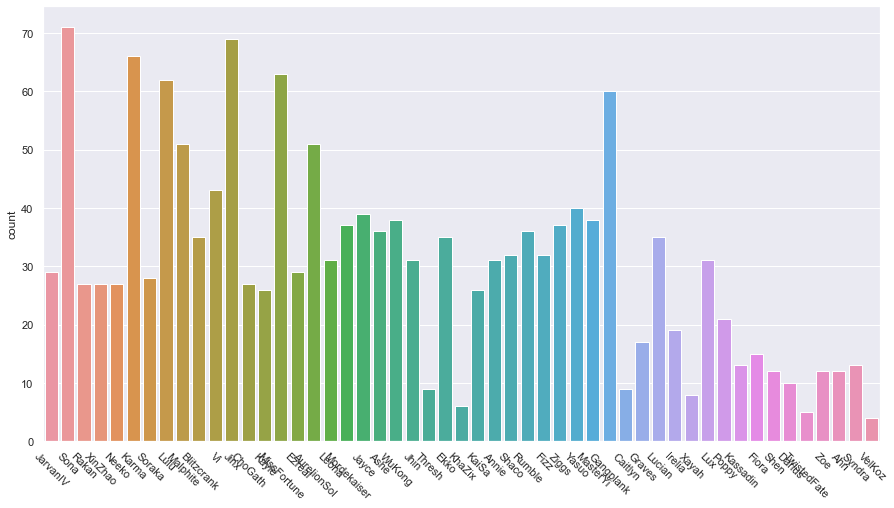

In [1788]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(rotation = - 45 )
sns.countplot(result)

In [1789]:
#champion_col3

In [1790]:
champion_dic = defaultdict(int)
for c in champion_col:
    champion_dic[c] = 0

In [1791]:
for i in range(len(masterData.champion)):
    dic = copy.deepcopy(champion_dic)
    col = json.loads(masterData.champion[i].replace("'", "\""))
    for k, v  in zip(col.keys(), col.values()):
        print(v["star"])
        if v["star"] == 3:
            dic[k] = 3
        if v["star"] == 2:
            dic[k] = 2
        if v["star"] == 1:
            dic[k] = 1
    masterData.champion[i] = dic

3
3
3
3
2
2
1
2
2
2
1
2
2
2
2
1
2
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
3
3
2
3
1
1
2
2
2
2
1
2
1
1
2
2
2
1
2
2
2
1
1
1
2
2
2
2
1
2
2
2
1
2
1
2
2
2
2
1
2
2
1
2
2
2
2
2
1
2
1
2
1
2
2
2
2
1
2
2
1
2
2
1
2
2
2
1
2
1
1
2
1
1
2
2
1
1
1
1
1
1
2
2
2
1
1
1
2
2
3
2
2
1
1
2
2
2
2
2
2
3
3
2
3
2
1
2
1
1
1
2
2
2
1
2
1
2
3
2
2
2
2
2
1
1
2
2
2
2
1
1
2
2
2
2
2
2
2
2
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
1
1
2
2
2
2
2
2
1
2
2
1
2
2
1
2
2
2
1
2
2
1
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
1
2
2
2
3
3
2
2
3
2
2
2
2
1
1
1
1
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
1
2
1
1
2
2
2
2
2
2
2
1
3
3
3
3
1
2
2
3
2
2
2
2
2
2
1
2
2
2
2
2
2
1
1
2
2
2
2
2
2
2
2
1
2
2
2
2
1
2
1
1
2
1
2
2
2
2
2
2
2
2
2
2
1
2
2
2
1
2
1
2
2
3
2
2
2
2
3
2
2
2
2
1
2
2
3
2
2
3
2
1
1
1
2
2
1
1
1
1
2
2
2
2
2
1
1
1
1
1
1
1
2
1
2
1
1
2
2
3
3
2
1
2
1
2
2
2
2
3
2
1
2
2
2
2
2
2
2
2
2
1
2
2
2
2
2
2
2
1
1
2
1
2
1
2
2
2
2
1
2
2
1
2
2
2
2
2
2
2
2
2
2
1
1
1
2
2
2
2
1
1
3
2
2
3
3
2
2
1
2
2
2
2
2
1
2
2
2
2
3
2
2
3
2
2
2
2
2
2
2
2
2
2
1
1
2
2
2
2
2
2
2
2
2
2
2
2
1
1
1
3
2


<ipython-input-1791-96986e510fc5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masterData.champion[i] = dic
C:\Users\dajin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


2
2
2
1
2
2
1
1
2
2
2
2
2
2
2
1
2
3
1
3
3
2
2
2
1
2
1
3
2
3
3
2
2
2
2
2
1
2
2
2
1
2
3
2
2
2
2
2
2
1
2
2
1
1
1
1
2
2
2
2
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
2
3
2
2
2
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
1
3
1
1
2
3
2
2
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
3
1
1
2
2
2
2
2
2
1
3
2
2
2
2
2
1
2
2
2
2
1
1
2
2
2
2
2
2
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
1
2
3
3
2
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
1
2
2
2
1
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
3
3
2
2
1
1
2
2
2
2
2
2
1
2
3
3
3
2
2
1
2
1
2
2
1
2
2
2
2
2
2
2
1
1
1
1
2
2
2
1
2
1
2
2
2
2
2
2
1
2
2
1
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
1
2
2
2
2
2
2
2
2
2
2
1
2
2
2
2
1
3
3
3
3
2
1
2
2
2
2
2
2
1
1
2
2
2
1
2
2
2
2
2
2
2
2
2
2
2
1
3
1
2
2
1
2
1
1
1
2
2
2
2
1
1
2
2
2
2
2
2
1
2
2
2
2
2
1
2
2
2
2
1
2
2
2
2
2
1
1
2
2
2
2
2
2
1
2
2
2
2
2
1
2
1
1
2
1
2
2
2
1
2
2
2
2
1
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
2
2
2
2
2
2
2
1
1
1
2
3
2
1
2
2
2
3
2
3


In [1816]:
masterData.head(5)

,gameId,gameDuration,level,lastRound,Ranked,ingameDuration,combination,champion
0,KR_4242528808,2233.449951,8,37,1,2225.243408,"{'DarkStar': 2, 'Protector': 4, 'Rebel': 1, 'S...","{'JarvanIV': {'items': [12], 'star': 3}, 'Sona..."
1,KR_4242528808,2233.449951,9,37,2,2225.243408,"{'Blaster': 2, 'Chrono': 1, 'Cybernetic': 1, '...","{'Malphite': {'items': [], 'star': 2}, 'Blitzc..."
2,KR_4242528808,2233.449951,8,35,3,2138.763428,"{'Blaster': 3, 'Chrono': 2, 'Cybernetic': 1, '...","{'Malphite': {'items': [], 'star': 2}, 'Blitzc..."
3,KR_4242528808,2233.449951,8,33,4,2003.865967,"{'Chrono': 2, 'Cybernetic': 2, 'DarkStar': 2, ...","{'Leona': {'items': [], 'star': 2}, 'Mordekais..."
4,KR_4242528808,2233.449951,7,31,5,1885.395386,"{'Blaster': 1, 'DarkStar': 1, 'Demolitionist':...","{'KhaZix': {'items': [], 'star': 2}, 'KaiSa': ..."


In [1793]:
len(levelData)

200

In [1794]:
masterData2_etc = pd.DataFrame(index=range(0,200), columns=['itemC', 'championC','starC','subDuration'])
masterData2_etc ['itemC'] = n
masterData2_etc ['championC'] = champion_col3
masterData2_etc ['starC'] = levelData
masterData2_etc ['subDuration'] = get_Duration

In [1795]:
masterData2_etc 

,itemC,championC,starC,subDuration
0,10,8,"{'level1': 1, 'level2': 3, 'level3': 4}",8.206543
1,9,9,"{'level1': 2, 'level2': 7, 'level3': 0}",8.206543
2,7,8,"{'level1': 1, 'level2': 7, 'level3': 0}",94.686523
3,8,8,"{'level1': 0, 'level2': 8, 'level3': 0}",229.583984
4,7,7,"{'level1': 2, 'level2': 2, 'level3': 3}",348.054565
...,...,...,...,...
195,11,8,"{'level1': 1, 'level2': 7, 'level3': 0}",137.349243
196,7,8,"{'level1': 2, 'level2': 6, 'level3': 0}",249.978149
197,5,7,"{'level1': 2, 'level2': 5, 'level3': 0}",256.850342
198,6,9,"{'level1': 5, 'level2': 4, 'level3': 0}",329.200195


In [1796]:
level = pd.DataFrame(columns=['star','level1','level2','level3','starP'])

In [1797]:
level['star'] = levelData
level['level1'] = levelData1
level['level2'] = levelData2
level['level3'] = levelData3
level['starP'] = propData

level

,star,level1,level2,level3,starP
0,"{'level1': 1, 'level2': 3, 'level3': 4}",1,3,4,"{'L1': 0.12, 'L2': 0.38, 'L3': 0.5}"
1,"{'level1': 2, 'level2': 7, 'level3': 0}",2,7,0,"{'L1': 0.22, 'L2': 0.78, 'L3': 0.0}"
2,"{'level1': 1, 'level2': 7, 'level3': 0}",1,7,0,"{'L1': 0.12, 'L2': 0.88, 'L3': 0.0}"
3,"{'level1': 0, 'level2': 8, 'level3': 0}",0,8,0,"{'L1': 0.0, 'L2': 1.0, 'L3': 0.0}"
4,"{'level1': 2, 'level2': 2, 'level3': 3}",2,2,3,"{'L1': 0.29, 'L2': 0.29, 'L3': 0.43}"
...,...,...,...,...,...
195,"{'level1': 1, 'level2': 7, 'level3': 0}",1,7,0,"{'L1': 0.12, 'L2': 0.88, 'L3': 0.0}"
196,"{'level1': 2, 'level2': 6, 'level3': 0}",2,6,0,"{'L1': 0.25, 'L2': 0.75, 'L3': 0.0}"
197,"{'level1': 2, 'level2': 5, 'level3': 0}",2,5,0,"{'L1': 0.29, 'L2': 0.71, 'L3': 0.0}"
198,"{'level1': 5, 'level2': 4, 'level3': 0}",5,4,0,"{'L1': 0.56, 'L2': 0.44, 'L3': 0.0}"


In [1798]:
# 머신러닝 들어가기 전 행열 확인 및 전처리
# 챔피언과 조합 열은 딥러닝 요소에서 다룰 계획 

In [1817]:
masterData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gameId          200 non-null    object 
 1   gameDuration    200 non-null    float64
 2   level           200 non-null    int64  
 3   lastRound       200 non-null    int64  
 4   Ranked          200 non-null    int64  
 5   ingameDuration  200 non-null    float64
 6   combination     200 non-null    object 
 7   champion        200 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 12.6+ KB


In [1800]:
masterData2_etc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   itemC        200 non-null    int64  
 1   championC    200 non-null    int64  
 2   starC        200 non-null    object 
 3   subDuration  200 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 6.4+ KB


In [1802]:
level.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   star    200 non-null    object
 1   level1  200 non-null    int64 
 2   level2  200 non-null    int64 
 3   level3  200 non-null    int64 
 4   starP   200 non-null    object
dtypes: int64(3), object(2)
memory usage: 7.9+ KB


In [1820]:
masterMachine = pd.concat([masterData, masterData2_etc], axis=1)
masterMachine = pd.concat([masterMachine, level], axis=1)

In [1821]:
masterMachine = masterMachine.drop(['gameId','star','champion','combination','starC', 'starP'], axis=1)

In [1822]:
masterMachine.head()

,gameDuration,level,lastRound,Ranked,ingameDuration,itemC,championC,subDuration,level1,level2,level3
0,2233.449951,8,37,1,2225.243408,10,8,8.206543,1,3,4
1,2233.449951,9,37,2,2225.243408,9,9,8.206543,2,7,0
2,2233.449951,8,35,3,2138.763428,7,8,94.686523,1,7,0
3,2233.449951,8,33,4,2003.865967,8,8,229.583984,0,8,0
4,2233.449951,7,31,5,1885.395386,7,7,348.054565,2,2,3


In [1823]:
masterMachine.columns

Index(['gameDuration', 'level', 'lastRound', 'Ranked', 'ingameDuration',
       'itemC', 'championC', 'subDuration', 'level1', 'level2', 'level3'],
      dtype='object')

In [1824]:
masterMachine = masterMachine[['Ranked','gameDuration', 'level', 'lastRound', 'ingameDuration',
       'itemC', 'championC', 'subDuration', 'level1', 'level2', 'level3']]

In [1825]:
masterMachine.head()

,Ranked,gameDuration,level,lastRound,ingameDuration,itemC,championC,subDuration,level1,level2,level3
0,1,2233.449951,8,37,2225.243408,10,8,8.206543,1,3,4
1,2,2233.449951,9,37,2225.243408,9,9,8.206543,2,7,0
2,3,2233.449951,8,35,2138.763428,7,8,94.686523,1,7,0
3,4,2233.449951,8,33,2003.865967,8,8,229.583984,0,8,0
4,5,2233.449951,7,31,1885.395386,7,7,348.054565,2,2,3


In [1826]:
masterMachine.Ranked = masterMachine.Ranked >= 4

In [1827]:
masterMachine["Ranked"] = masterMachine["Ranked"]+1

In [1828]:
masterMachine.head()

,Ranked,gameDuration,level,lastRound,ingameDuration,itemC,championC,subDuration,level1,level2,level3
0,1,2233.449951,8,37,2225.243408,10,8,8.206543,1,3,4
1,1,2233.449951,9,37,2225.243408,9,9,8.206543,2,7,0
2,1,2233.449951,8,35,2138.763428,7,8,94.686523,1,7,0
3,2,2233.449951,8,33,2003.865967,8,8,229.583984,0,8,0
4,2,2233.449951,7,31,1885.395386,7,7,348.054565,2,2,3


In [1829]:
masterMachine.corr('spearman')

,Ranked,gameDuration,level,lastRound,ingameDuration,itemC,championC,subDuration,level1,level2,level3
Ranked,1.000000,0.000000,-0.366082,-0.816169,-0.798115,-0.501619,-0.380356,0.810100,0.176769,-0.204602,-0.224323
gameDuration,0.000000,1.000000,0.102461,0.108164,0.177350,0.080784,0.096759,0.131352,-0.054714,0.041763,0.021780
level,-0.366082,0.102461,1.000000,0.560946,0.574944,0.429505,0.902250,-0.523043,0.000248,0.581543,-0.256501
lastRound,-0.816169,0.108164,0.560946,1.000000,0.982050,0.716075,0.582616,-0.942930,-0.276743,0.409317,0.214252
ingameDuration,-0.798115,0.177350,0.574944,0.982050,1.000000,0.684892,0.585442,-0.931087,-0.289551,0.421792,0.202059
itemC,-0.501619,0.080784,0.429505,0.716075,0.684892,1.000000,0.492895,-0.648436,-0.212925,0.363171,0.101057
championC,-0.380356,0.096759,0.902250,0.582616,0.585442,0.492895,1.000000,-0.541660,0.026066,0.597331,-0.232343
subDuration,0.810100,0.131352,-0.523043,-0.942930,-0.931087,-0.648436,-0.541660,1.000000,0.248035,-0.382584,-0.191263
level1,0.176769,-0.054714,0.000248,-0.276743,-0.289551,-0.212925,0.026066,0.248035,1.000000,-0.543958,-0.298167
level2,-0.204602,0.041763,0.581543,0.409317,0.421792,0.363171,0.597331,-0.382584,-0.543958,1.000000,-0.424442


<AxesSubplot:>

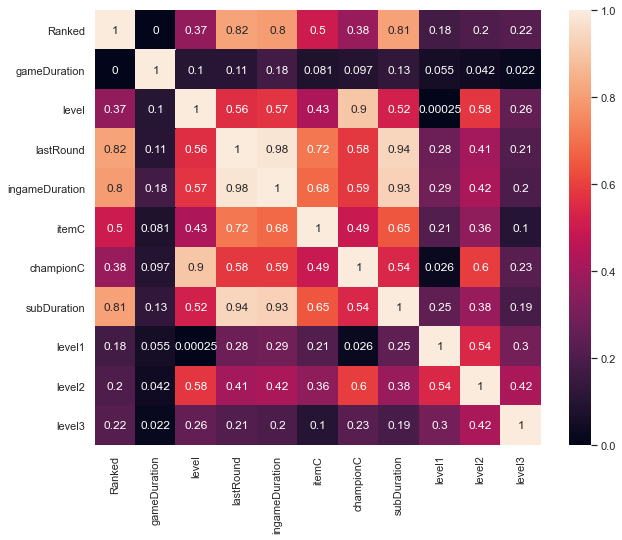

In [1830]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(masterMachine.corr('spearman').abs(),annot=True)

1. Ranked(순위)와 연관되어 있는 것 중 lastRound, ingame, subDuration, itemC 가 강한 상관성이 있음을 볼 수 있다.
2. 그 중 lastRound, ingame, subDuration은 다중 공산성이 높을 것으로 예상된다. 
3. subDuration의 경우 (총 게임의 시간 - 자신이 게임 한 시간)으로 순위가 좋을 수록 subDuration의 편차가 작지만,
0.9이상의 가장 강한 상관성이 아니기 때문에 고려해야한다. 
4. 히트맵으로 보았을 때, level(=별의 갯수)의 경우 양의 상관성은 띄고 있으나, 3개짜리가 제일 연관성이 높다라고 할 수 있다. 

________________________________________________________________________________________________________________________________________

2. level, chap_name, gameDuration, chap_len간의 상관성 

C:\Users\dajin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Ranked'>

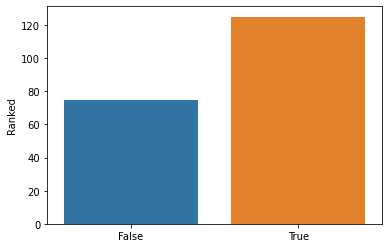

In [1603]:
#seaborn
import seaborn as sns
sns.barplot(masterMachine.Ranked.value_counts().index, masterMachine.Ranked.value_counts())

- Ranked의 경우, 실패(4등 이하)는 75명, 성공(4등 이상)는 125명이 존재한다. 

C:\Users\dajin\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ingameDuration', ylabel='Density'>

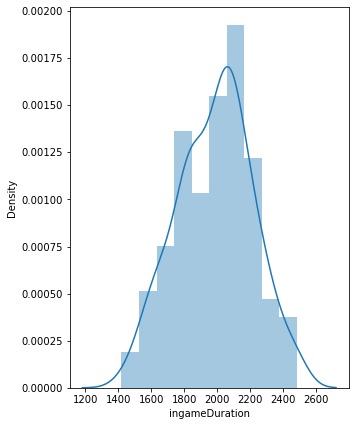

In [1608]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 7))
sns.distplot(masterMachine.ingameDuration, ax=ax)

In [1616]:
masterMachine.groupby('Ranked').ingameDuration.agg(['min','mean','std','max'])

,min,mean,std,max
Ranked,,,,
False,1970.808838,2202.714268,126.567885,2483.647949
True,1418.434570,1855.653358,167.011165,2165.411621


C:\Users\dajin\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='subDuration', ylabel='Density'>

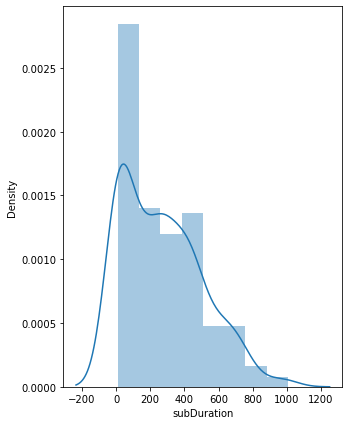

In [1609]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 7))
sns.distplot(masterMachine.subDuration, ax=ax)

In [1617]:
masterMachine.groupby('Ranked').subDuration.agg(['min','mean','std','max'])

,min,mean,std,max
Ranked,,,,
False,8.176025,51.488975,81.226447,359.242432
True,84.211670,398.549884,196.259842,1007.616821


C:\Users\dajin\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='lastRound', ylabel='Density'>

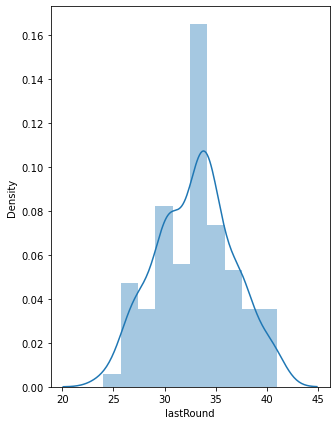

In [1611]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 7))
sns.distplot(masterMachine.lastRound, ax=ax)

In [1618]:
masterMachine.groupby('Ranked').lastRound.agg(['min','mean','std','max'])

,min,mean,std,max
Ranked,,,,
False,33,36.653333,2.127639,41
True,24,30.752000,2.598560,35


In [1626]:
pd.crosstab(masterMachine.level1,masterMachine.Ranked)

Ranked,False,True
level1,,
0,22,10
1,23,30
2,22,34
3,4,27
4,4,14
5,0,7
6,0,2
7,0,1


In [1630]:
pd.crosstab(masterMachine.level2, masterMachine.Ranked)

Ranked,False,True
level2,,
1,2,2
2,2,7
3,4,14
4,3,26
5,11,21
6,18,30
7,20,20
8,10,4
9,5,1


<AxesSubplot:xlabel='level1,championC'>

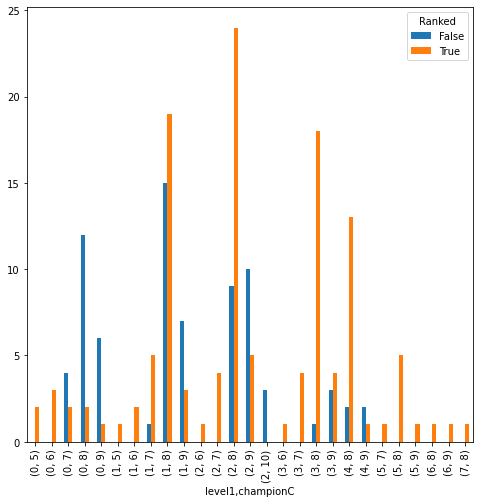

In [1652]:
pd.crosstab([masterMachine.level1, masterMachine.championC], masterMachine.Ranked)

fig, ax = plt.subplots(figsize=(8, 8))
(
 masterMachine.pipe(lambda df_: pd.crosstab([masterMachine.level1, masterMachine.championC], masterMachine.Ranked))
 .plot.bar(ax=ax)
)

<AxesSubplot:xlabel='level2,championC'>

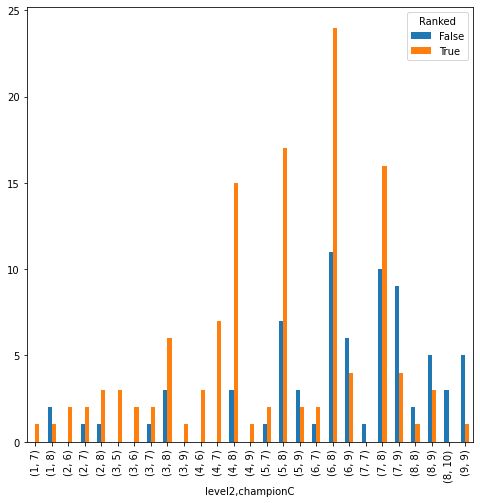

In [1651]:
pd.crosstab([masterMachine.level2, masterMachine.championC], masterMachine.Ranked)

fig, ax = plt.subplots(figsize=(8, 8))
(
 masterMachine.pipe(lambda df_: pd.crosstab([masterMachine.level2, masterMachine.championC], masterMachine.Ranked))
 .plot.bar(ax=ax)
)

<AxesSubplot:xlabel='level3,championC'>

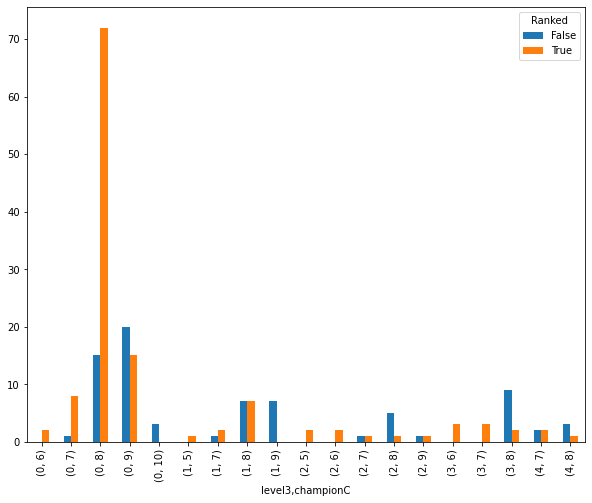

In [1649]:
pd.crosstab([masterMachine.level3, masterMachine.championC], masterMachine.Ranked)

fig, ax = plt.subplots(figsize=(10, 8))
(
 masterMachine.pipe(lambda df_: pd.crosstab([masterMachine.level3, masterMachine.championC], masterMachine.Ranked))
 .plot.bar(ax=ax)
)

<AxesSubplot:ylabel='Density'>

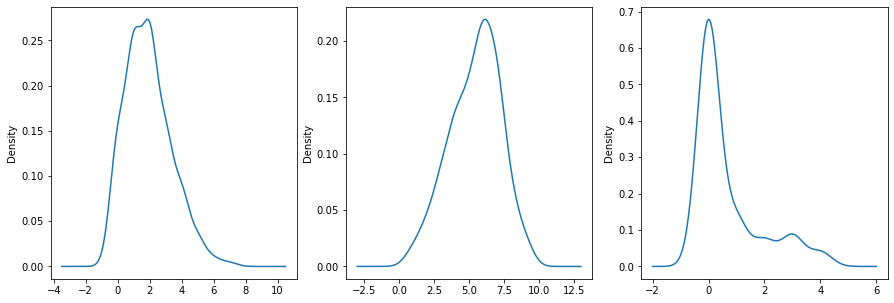

In [1646]:
import matplotlib.pyplot as plt
figure, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols=3) 
figure.set_size_inches(15,5) 
masterMachine['level1'].plot.kde(ax= ax1)
masterMachine['level2'].plot.kde(ax= ax2)
masterMachine['level3'].plot.kde(ax= ax3)

________________________________________________________________________________________________________________________________________

### 머신러닝 기법 분류 모델  

In [1054]:
#sns.pairplot(masterMachine)

In [1287]:
X, y = masterMachine.iloc[:,1:].values, masterMachine.iloc[:,0].values
#option2
#X, y = tft_data.loc[:,tft_data.columns != 'Ranked'].values, tft_data.iloc[:,2].values
#optionN-1
#X_train, X_test, y_train#kkn, y_test = train_test_split(X, y, test_size= 0.3, random_state=1, stratify = y)
#optionN-2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=0, stratify = y)

In [1288]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [1289]:
from sklearn.preprocessing import StandardScaler

sc =  StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [1290]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0 =0.1, random_state =0)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1)

In [1291]:
y_pred = ppn.predict(X_test_std)
print('잘못 분류된 샘플 개수 : %d' %(y_test != y_pred).sum())

잘못 분류된 샘플 개수 : 6


In [1292]:
#정확도 
from sklearn.metrics import accuracy_score
print('정확도 : %.3f' %accuracy_score(y_test, y_pred))

정확도 : 0.900


In [1295]:
#KNN 분류기

In [1297]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [1298]:
knn = KNeighborsClassifier(n_neighbors = 3)

In [1299]:
knn.fit(X_train_std, y_train)
print('훈련정확도:' ,knn.score(X_train_std, y_train))

훈련정확도: 0.9214285714285714


In [1300]:
print('훈련정확도:' ,knn.score(X_test_std, y_test))

훈련정확도: 0.8333333333333334


### 랜덤 포레스트 알고리즘

In [1301]:
from sklearn.ensemble import RandomForestClassifier

In [1302]:
feat_labels = masterMachine.columns[1:]

In [1303]:
forest = RandomForestClassifier(n_estimators = 500, 
                               random_state = 0)

In [1304]:
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=0)

In [1305]:
importances = forest.feature_importances_

In [1306]:
indices = np.argsort(importances)[::-1]

In [1307]:
for i in range(X_train.shape[1]):
    print("%2d) %-*s %f" %(i +1, 30,
                          feat_labels[indices[i]],
                          importances[indices[i]]))

 1) lastRound                      0.291405
 2) subDuration                    0.277720
 3) ingameDuration                 0.253110
 4) itemC                          0.055451
 5) gameDuration                   0.029400
 6) level2                         0.027474
 7) level                          0.020632
 8) level3                         0.015678
 9) level1                         0.015663
10) championC                      0.013468


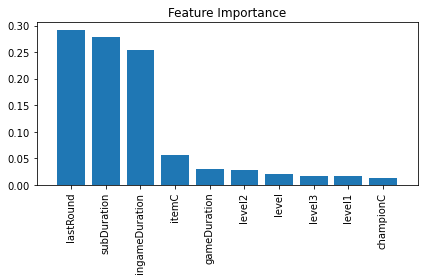

In [1308]:
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]),
       importances[indices], 
       align = 'center')
plt.xticks(range(X_train.shape[1]),
       feat_labels[indices], rotation =90) 
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [1309]:
from sklearn.feature_selection import SelectFromModel

In [1310]:
sfm = SelectFromModel(forest, threshold = 0.1, prefit =True)
X_selected = sfm.transform(X_train)
print('임계값 조건 만족하는 샘플하는 수 : ', X_selected.shape[1])

임계값 조건 만족하는 샘플하는 수 :  3


In [1311]:
for i in range(X_selected.shape[1]):
    print("%2d) %-*s %f" %(i+1, 30,
                          feat_labels[indices[i]],
                          importances[indices[i]]))

 1) lastRound                      0.291405
 2) subDuration                    0.277720
 3) ingameDuration                 0.253110


In [1312]:
#RFE

In [1313]:
from sklearn.feature_selection import RFE
rfe = RFE(forest, n_features_to_select = 3)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(n_estimators=500, random_state=0),
    n_features_to_select=3)

In [1314]:
rfe.ranking_

array([3, 5, 1, 1, 2, 8, 1, 6, 4, 7])

In [1315]:
f_mask = rfe.support_

In [1316]:
importances = rfe.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

In [1317]:
for i in indices:
    print("%2d) %-*s %f" %(i+1, 30,
                          feat_labels[f_mask][i],
                          importances[i]))

 3) subDuration                    0.354208
 2) ingameDuration                 0.331176
 1) lastRound                      0.314616


### 주성분 분석

In [1318]:
X, y = masterMachine.iloc[:,1:].values, masterMachine.iloc[:,0].values
#option2
#X, y = tft_data.loc[:,tft_data.columns != 'Ranked'].values, tft_data.iloc[:,2].values
#optionN-1
#X_train, X_test, y_train#kkn, y_test = train_test_split(X, y, test_size= 0.3, random_state=1, stratify = y)
#optionN-2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=0, stratify = y)

In [1319]:
#특성 표준화
from sklearn.preprocessing import StandardScaler

sc =  StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [1320]:
import numpy as np

In [1321]:
#공분산 형태에 대한 고유 벡터와 고유값 쌍 계산 
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\n고유값\n%s' %eigen_vals)


고유값
[ 4.6142e+00  2.1255e+00  1.2493e+00  1.0602e+00  4.7089e-01  3.6777e-01
  1.6237e-01  2.1814e-02 -1.1042e-16  1.7841e-16]


In [1322]:
tot = sum(eigen_vals)
var_exp =[(i /tot) for i in
         sorted(eigen_vals, reverse =True)]
cum_var_exp =np.cumsum(var_exp)

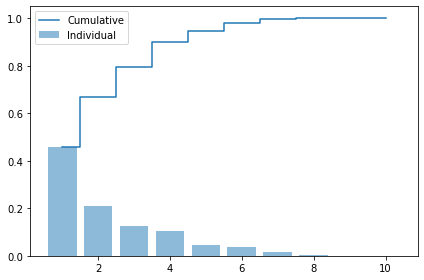

In [1323]:
import matplotlib.pyplot as plt
plt.bar(range(1,11), var_exp, alpha = 0.5, align ='center',
       label ="Individual")
plt.step(range(1,11), cum_var_exp, where ='mid',
       label ="Cumulative")
plt.legend(loc ='best')
plt.tight_layout()
plt.show()

In [1324]:
#특성변환 

In [1325]:
eigen_pairs =[(np.abs(eigen_vals[i]), eigen_vecs[:, i])
             for i in range(len(eigen_vals))]

In [1326]:
eigen_pairs.sort(key = lambda k:k[0], reverse =True)

In [1327]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
              eigen_pairs[1][1][:, np.newaxis]))

print('투명 행렬 W:\n', w)

투명 행렬 W:
 [[-0.0352  0.1625]
 [ 0.3259 -0.3912]
 [ 0.4248  0.2197]
 [ 0.4124  0.244 ]
 [ 0.3588  0.1379]
 [ 0.3293 -0.339 ]
 [-0.411  -0.1473]
 [-0.163  -0.3838]
 [ 0.3216 -0.2358]
 [-0.0771  0.5951]]


In [1328]:
X_train_std[0].dot(w)

array([-2.9953,  2.8901])

In [1329]:
X_train_pca = X_train_std.dot(w)

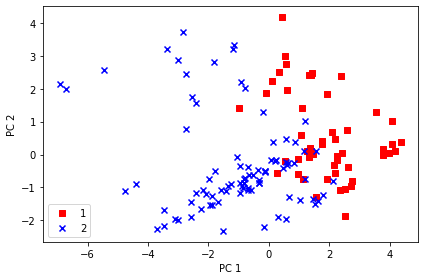

In [1330]:
colors = ['r','b']
markers =['s','x']
for l,c,m in zip(np.unique(y_train), colors , markers):
    plt.scatter(X_train_pca[y_train==l, 0],
               X_train_pca[y_train==l, 1],
               c=c, label =l, marker = m)
    
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc ='lower left')
plt.tight_layout()
plt.show()

In [1331]:
#사이킷런의 주성분 분석

In [1332]:
#PCA p.200 참고 

from matplotlib.colors import ListedColormap

In [1366]:
X

array([[2.1425e+03, 8.0000e+00, 3.5000e+01, ..., 1.0000e+00, 3.0000e+00,
        4.0000e+00],
       [2.1425e+03, 9.0000e+00, 3.5000e+01, ..., 2.0000e+00, 7.0000e+00,
        0.0000e+00],
       [2.1425e+03, 8.0000e+00, 3.4000e+01, ..., 1.0000e+00, 6.0000e+00,
        1.0000e+00],
       ...,
       [2.1975e+03, 8.0000e+00, 3.0000e+01, ..., 1.0000e+00, 7.0000e+00,
        0.0000e+00],
       [2.1975e+03, 8.0000e+00, 2.7000e+01, ..., 5.0000e+00, 3.0000e+00,
        0.0000e+00],
       [2.1975e+03, 8.0000e+00, 2.6000e+01, ..., 4.0000e+00, 4.0000e+00,
        0.0000e+00]])

In [1333]:
def plot_decision_regions(X, y, classifier, resolution=0.02):

    # 마커와 컬러맵을 준비합니다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 클래스별로 샘플을 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor=None if idx==1 else 'black',
                    marker=markers[idx], 
                    label=cl)

In [1334]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
lr = LogisticRegression(random_state = 0)

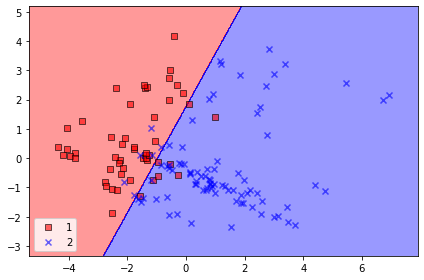

In [1335]:
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.fit_transform(X_test_std)

#축소된 데이터 셋으로 로지스틱 회귀모델 훈련
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier = lr)
plt.legend(loc ='lower left')
plt.tight_layout()
plt.show()

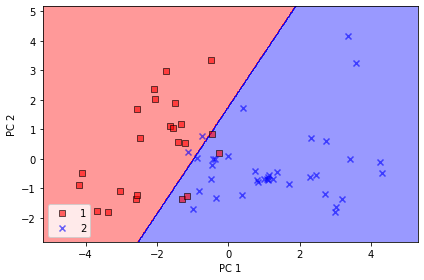

In [1336]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_05.png', dpi=300)
plt.show()

In [1337]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([4.5812e-01, 2.1103e-01, 1.2404e-01, 1.0526e-01, 4.6752e-02,
       3.6514e-02, 1.6121e-02, 2.1658e-03, 7.1258e-33, 4.4483e-33])

In [1338]:
pca = PCA(n_components=0.95)
pca.fit(X_train_std)
print('주성분 개수:', pca.n_components_)
print('설명된 분산 비율:', np.sum(pca.explained_variance_ratio_))

주성분 개수: 6
설명된 분산 비율: 0.9817130549878574


In [1339]:
pca = PCA(n_components='mle')
pca.fit(X_train_std)
print('주성분 개수:', pca.n_components_)
print('설명된 분산 비율:', np.sum(pca.explained_variance_ratio_))

주성분 개수: 8
설명된 분산 비율: 1.0000000000000002


In [1340]:
from sklearn.decomposition import IncrementalPCA

ipca = IncrementalPCA(n_components=9)
for batch in range(len(X_train_std)//25+1):
    X_batch = X_train_std[batch*25:(batch+1)*25]
    ipca.partial_fit(X_batch)

print('주성분 개수:', ipca.n_components_)
print('설명된 분산 비율:', np.sum(ipca.explained_variance_ratio_))

주성분 개수: 9
설명된 분산 비율: 1.0000000000000013


In [1341]:
#선형 판별분석 error남

In [1343]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 3):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))


MV 1: [-0.0337  0.4424  0.9763  0.951   0.5713  0.4177 -0.9229 -0.4414  0.3894
  0.2134]

MV 2: [ 0.0199 -0.2614 -0.5769 -0.5619 -0.3376 -0.2468  0.5453  0.2608 -0.2301
 -0.1261]



In [1351]:
d = 10 # 특성의 수
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 3), mean_vecs):
    class_scatter = np.zeros((d, d))  # 각 클래스에 대한 산포 행렬
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # 열 벡터를 만듭니다
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # 클래스 산포 행렬을 더합니다

print('클래스 내의 산포 행렬: %sx%s' % (S_W.shape[0], S_W.shape[1]))

클래스 내의 산포 행렬: 10x10


In [1352]:
print('클래스 레이블 분포: %s' 
      % np.bincount(y_train)[1:])

클래스 레이블 분포: [52 88]


In [1353]:
d = 10  # 특성의 수
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 3), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('스케일 조정된 클래스 내의 산포 행렬: %sx%s' % 
      (S_W.shape[0], S_W.shape[1]))

스케일 조정된 클래스 내의 산포 행렬: 10x10


In [1354]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)  # 열 벡터로 만들기
d = 10  # 특성 개수
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # 열 벡터로 만들기
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('클래스 간의 산포 행렬: %sx%s' % (S_B.shape[0], S_B.shape[1]))

클래스 간의 산포 행렬: 10x10


In [1355]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

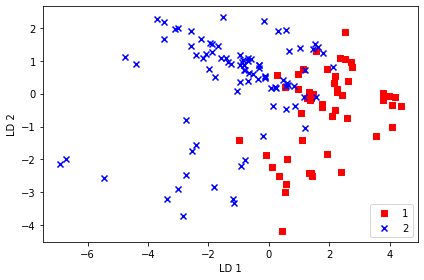

In [1356]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('images/05_08.png', dpi=300)
plt.show()

In [1359]:
y_train

array([2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1,
       2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2,
       2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1,
       2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2,
       1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 2, 2, 2])

In [1364]:
y_train

array([2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1,
       2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2,
       2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1,
       2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2,
       1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 2, 2, 2])

### 커널 PCA 

In [1271]:
from sklearn.datasets import make_moons #반달 
from sklearn.datasets import make_circles #동심원

In [1266]:
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import numpy as np

from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version

# scipy 2.0.0에서 삭제될 예정이므로 대신 numpy.exp를 사용합니다.
if scipy_version >= Version('1.4.1'):
    from numpy import exp
else:
    from scipy import exp


def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF 커널 PCA 구현

    매개변수
    ------------
    X: {넘파이 ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      RBF 커널 튜닝 매개변수
        
    n_components: int
      반환할 주성분 개수

    반환값
    ------------
     X_pc: {넘파이 ndarray}, shape = [n_samples, k_features]
       투영된 데이터셋

    """
    # MxN 차원의 데이터셋에서 샘플 간의 유클리디안 거리의 제곱을 계산합니다.
    sq_dists = pdist(X, 'sqeuclidean')

    # 샘플 간의 거리를 정방 대칭 행렬로 변환합니다.
    mat_sq_dists = squareform(sq_dists)

    # 커널 행렬을 계산합니다.
    K = exp(-gamma * mat_sq_dists)

    # 커널 행렬을 중앙에 맞춥니다.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # 중앙에 맞춰진 커널 행렬의 고윳값과 고유벡터를 구합니다.
    # scipy.linalg.eigh 함수는 오름차순으로 반환합니다.
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # 최상위 k 개의 고유벡터를 선택합니다(결과값은 투영된 샘플입니다).
    X_pc = np.column_stack([eigvecs[:, i]
                            for i in range(n_components)])

    return X_pc

In [1270]:
#새로운 포인트 투영

from scipy.spatial.distance import pdist, squareform
from numpy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF 커널 PCA 구현

    매개변수
    ------------
    X: {넘파이 ndarray}, shape = [n_samples, n_features]
        
    gamma: float
      RBF 커널 튜닝 매개변수
        
    n_components: int
      반환할 주성분 개수

    Returns
    ------------
     alphas: {넘파이 ndarray}, shape = [n_samples, k_features]
       투영된 데이터셋
     
     lambdas: list
       고윳값

    """
    # MxN 차원의 데이터셋에서 샘플 간의 유클리디안 거리의 제곱을 계산합니다.
    sq_dists = pdist(X, 'sqeuclidean')

    # 샘플 간의 거리를 정방 대칭 행렬로 변환합니다.
    mat_sq_dists = squareform(sq_dists)

    # 커널 행렬을 계산합니다.
    K = exp(-gamma * mat_sq_dists)

    # 커널 행렬을 중앙에 맞춥니다.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # 중앙에 맞춰진 커널 행렬의 고윳값과 고유 벡터를 구합니다.
    # scipy.linalg.eigh 함수는 오름차순으로 반환합니다.
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # 최상위 k 개의 고유 벡터를 선택합니다(투영 결과).
    alphas = np.column_stack([eigvecs[:, i]
                              for i in range(n_components)])

    # 고유 벡터에 상응하는 고윳값을 선택합니다.
    lambdas = [eigvals[i] for i in range(n_components)]

    return alphas, lambdas

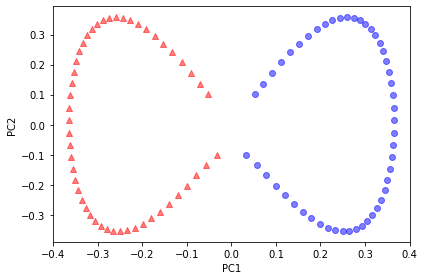

In [1272]:
#사이킷런의 커널 PCA

from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
# plt.savefig('images/05_19.png', dpi=300)
plt.show()

In [1273]:
def plot_manifold(X, y, savefig_name):
    
    plt.scatter(X[y == 0, 0], X[y == 0, 1], 
                color='red', marker='^', alpha=0.5)
    plt.scatter(X[y == 1, 0], X[y == 1, 1],
                color='blue', marker='o', alpha=0.5)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.tight_layout()
    # plt.savefig(savefig_name, dpi=300)
    plt.show()

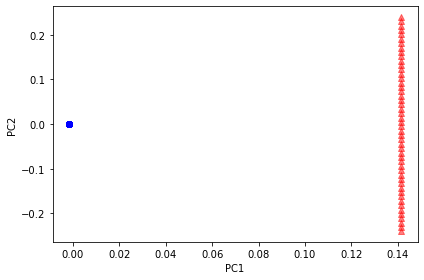

In [1277]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, random_state=0)
X_lle = lle.fit_transform(X)

plot_manifold(X_lle, y, 'images/05_lle_moon.png')


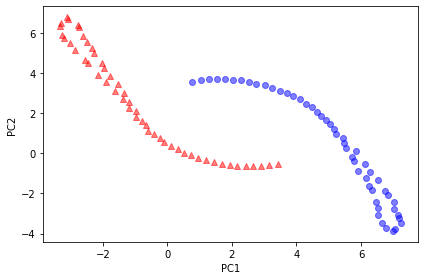

In [1278]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X)

plot_manifold(X_tsne, y, 'images/05_tsne_moon.png')

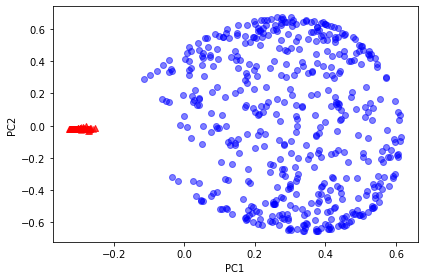

In [1279]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plot_manifold(X_skernpca, y, 'images/05_kpca_circles.png')

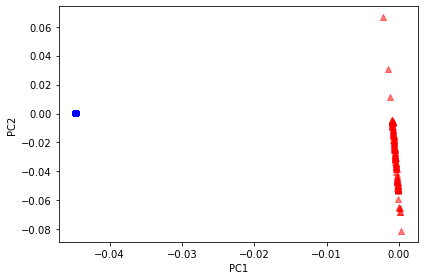

In [1280]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, random_state=0)
X_lle = lle.fit_transform(X)

plot_manifold(X_lle, y, 'images/05_lle_circles.png')

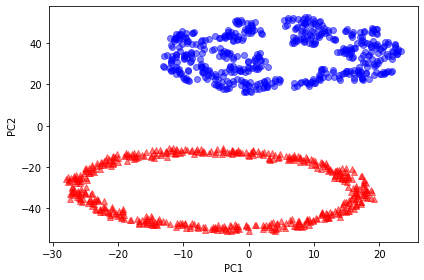

In [1281]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

plot_manifold(X_tsne, y, 'images/05_tsne_circles.png')

### 모델 평가와 하이퍼파라미터 튜닝의 모범 사례 - 6장 참고

In [1376]:
masterMachine

,Ranked,gameDuration,level,lastRound,ingameDuration,itemC,championC,subDuration,level1,level2,level3
0,False,2142.470703,8,35,2134.272217,8,8,8.198486,1,3,4
1,False,2142.470703,9,35,2134.272217,12,9,8.198486,2,7,0
2,False,2142.470703,8,34,2073.459229,10,8,69.011475,1,6,1
3,True,2142.470703,8,33,1998.146729,10,8,144.323975,2,6,0
4,True,2142.470703,9,33,1986.443237,9,9,156.027466,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...
195,True,2197.485352,8,34,1972.834595,10,8,224.650757,1,6,1
196,True,2197.485352,8,31,1794.755371,8,8,402.729980,3,5,0
197,True,2197.485352,8,30,1730.138550,8,8,467.346802,1,7,0
198,True,2197.485352,8,27,1569.026489,5,8,628.458862,5,3,0


In [1373]:
masterMachine.Ranked = masterMachine.Ranked >= 2

In [1378]:
from sklearn.preprocessing import LabelEncoder

X = masterMachine.iloc[:, 1:].values
y = masterMachine.iloc[:, 0].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array([False,  True])

In [1379]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.30,
                     stratify=y,
                     random_state=0)

In [1382]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=0))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.917


In [1383]:
import matplotlib.pyplot as plt
from sklearn import set_config
set_config(display='diagram')
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=0))])

In [1384]:
#k-겹 교차 검증을 사용한 모델 성능 평가 
#1. 홀드아웃 교차 검증, 2. K-겹 교차 검증 

In [1385]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

폴드:  1, 클래스 분포: [47 79], 정확도: 1.000
폴드:  2, 클래스 분포: [47 79], 정확도: 0.929
폴드:  3, 클래스 분포: [47 79], 정확도: 0.857
폴드:  4, 클래스 분포: [47 79], 정확도: 1.000
폴드:  5, 클래스 분포: [47 79], 정확도: 0.786
폴드:  6, 클래스 분포: [47 79], 정확도: 0.857
폴드:  7, 클래스 분포: [47 79], 정확도: 0.929
폴드:  8, 클래스 분포: [47 79], 정확도: 0.857
폴드:  9, 클래스 분포: [46 80], 정확도: 0.857
폴드: 10, 클래스 분포: [46 80], 정확도: 0.929

CV 정확도: 0.900 +/- 0.065


In [1386]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도 점수: [1.     0.9286 0.8571 1.     0.7857 0.8571 0.9286 0.8571 0.8571 0.9286]
CV 정확도: 0.900 +/- 0.065


In [1387]:
from sklearn.model_selection import cross_validate

scores = cross_validate(estimator=pipe_lr, 
                        X=X_train, 
                        y=y_train, 
                        scoring=['accuracy'], 
                        cv=10, 
                        n_jobs=-1)
print('CV 정확도 점수: %s' % scores['test_accuracy'])
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']), 
                                 np.std(scores['test_accuracy'])))

CV 정확도 점수: [1.     0.9286 0.8571 1.     0.7857 0.8571 0.9286 0.8571 0.8571 0.9286]
CV 정확도: 0.900 +/- 0.065


In [1388]:
from sklearn.model_selection import cross_val_predict

preds = cross_val_predict(estimator=pipe_lr,
                          X=X_train, 
                          y=y_train,
                          cv=10, 
                          n_jobs=-1)
preds[:10]

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 1], dtype=int64)

In [1390]:
from sklearn.model_selection import cross_val_predict

preds = cross_val_predict(estimator=pipe_lr,
                          X=X_train, 
                          y=y_train,
                          cv=10, 
                          method='predict_proba', 
                          n_jobs=-1)
preds[:10]

array([[1.7504e-02, 9.8250e-01],
       [3.9444e-05, 9.9996e-01],
       [3.2285e-01, 6.7715e-01],
       [9.9722e-01, 2.7804e-03],
       [1.6785e-01, 8.3215e-01],
       [9.0371e-01, 9.6289e-02],
       [2.5603e-01, 7.4397e-01],
       [1.5427e-01, 8.4573e-01],
       [4.4181e-02, 9.5582e-01],
       [2.6898e-01, 7.3102e-01]])

In [1391]:
#학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

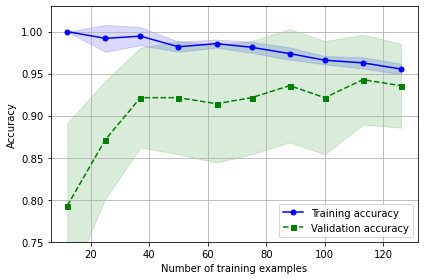

In [1396]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1,
                                           max_iter=10000))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.75, 1.03])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

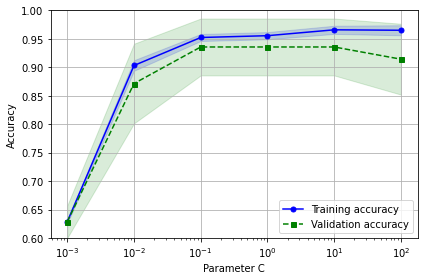

In [1401]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.60, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

In [1402]:
#그리드 서치를 이용한 머신러닝 모델 세뷰 튜닝
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.95
{'svc__C': 1.0, 'svc__kernel': 'linear'}


In [1403]:
clf = gs.best_estimator_

# refit=True로 지정했기 때문에 다시 fit() 메서드를 호출할 필요가 없습니다.
# clf.fit(X_train, y_train)

print('테스트 정확도: %.3f' % clf.score(X_test, y_test))

테스트 정확도: 0.917


In [1404]:
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  return_train_score=True,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)

In [1405]:
#전체 훈련의 평균값
gs.cv_results_['split0_train_score']

array([0.627 , 0.627 , 0.9127, 0.9524, 0.9524, 0.9603, 0.9603, 0.9603,
       0.627 , 0.627 , 0.627 , 0.627 , 0.627 , 0.627 , 0.627 , 0.627 ,
       0.627 , 0.627 , 0.627 , 0.627 , 0.627 , 0.627 , 0.627 , 0.627 ,
       0.627 , 0.627 , 0.627 , 0.627 , 0.627 , 0.627 , 0.627 , 0.627 ,
       0.627 , 0.627 , 0.627 , 0.8889, 0.627 , 0.627 , 0.627 , 0.627 ,
       0.627 , 0.6429, 0.9127, 0.9603, 0.9921, 1.    , 1.    , 1.    ,
       0.6508, 0.9127, 0.9524, 0.9762, 1.    , 1.    , 1.    , 1.    ,
       0.9127, 0.9524, 0.9603, 0.9921, 1.    , 1.    , 1.    , 1.    ,
       0.9524, 0.9524, 0.9841, 1.    , 1.    , 1.    , 1.    , 1.    ])

In [1406]:
gs.cv_results_['mean_train_score']

array([0.6286, 0.6286, 0.9278, 0.9516, 0.9579, 0.9619, 0.9627, 0.9635,
       0.6286, 0.6286, 0.6286, 0.6286, 0.6286, 0.6286, 0.6286, 0.6286,
       0.6286, 0.6286, 0.6286, 0.6286, 0.6286, 0.6286, 0.6286, 0.6286,
       0.6286, 0.6286, 0.6286, 0.6286, 0.6286, 0.6286, 0.6286, 0.6286,
       0.6286, 0.6286, 0.6286, 0.8778, 0.6286, 0.6286, 0.6286, 0.6286,
       0.6286, 0.6405, 0.9222, 0.946 , 0.9937, 1.    , 1.    , 1.    ,
       0.6437, 0.9246, 0.954 , 0.9817, 1.    , 1.    , 1.    , 1.    ,
       0.9246, 0.9548, 0.9706, 0.9937, 1.    , 1.    , 1.    , 1.    ,
       0.954 , 0.9563, 0.9857, 1.    , 1.    , 1.    , 1.    , 1.    ])

In [1407]:
print('테스트 정확도: %.3f' % gs.score(X_test, y_test))

테스트 정확도: 0.917


In [1408]:
#랜덤한 하이퍼파라미터

In [1409]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

distribution =  loguniform(0.0001, 1000.0)

param_dist = [{'svc__C': distribution, 
               'svc__kernel': ['linear']},
              {'svc__C': distribution, 
               'svc__gamma': distribution, 
               'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_dist,
                        n_iter=30,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)
rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

0.95
{'svc__C': 1.3339475641277247, 'svc__kernel': 'linear'}


In [1410]:
# n_iter값 찾기 // RandomizedSearchCV의 탐색 횟수는 절반 이상 적지만 거의 비슷한 성능을 내는 매개변수 조합

In [1411]:
#중첩 교차 검증을 사용한 알고리즘 선택

In [1412]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

CV 정확도: 0.929 +/- 0.051


In [1413]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV 정확도: 0.907 +/- 0.058


In [1414]:
#여러가지 성능 지표

In [1415]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[20  3]
 [ 3 34]]


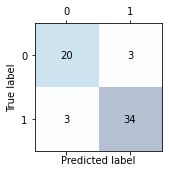

In [1416]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
# plt.savefig('images/06_09.png', dpi=300)
plt.show()

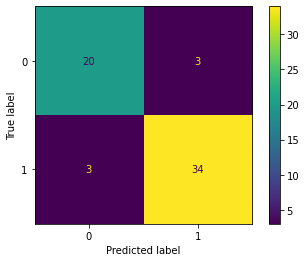

In [1423]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipe_svc, X_test, y_test)

#from sklearn.metrics import ConfusionMatrixDisplay
#ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test)

# plt.savefig('images/06_plot_confusion_matrix.png', dpi=300)
plt.show()

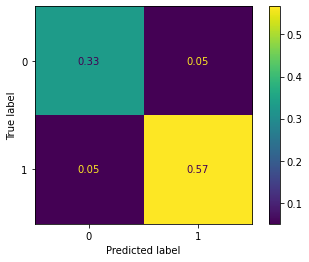

In [1428]:
from sklearn.metrics import ConfusionMatrixDisplay
plot_confusion_matrix(pipe_svc, X_test, y_test, 
                      normalize='all')
# plt.savefig('images/06_plot_confusion_matrix_normalize.png', dpi=300)
plt.show()

In [1431]:
le.transform([False,  True])

array([0, 1], dtype=int64)

In [1432]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[20  3]
 [ 3 34]]


In [1433]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
print(confmat)

[[34  3]
 [ 3 20]]


In [1435]:
#분류 모델의 정밀도와 재현율 최적화 

In [1434]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

정밀도: 0.919
재현율: 0.919
F1: 0.919


In [1436]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9297979797979797
{'svc__C': 1.0, 'svc__kernel': 'linear'}


In [1437]:
#ROC 곡선 

In [1447]:
len(X_train)

140

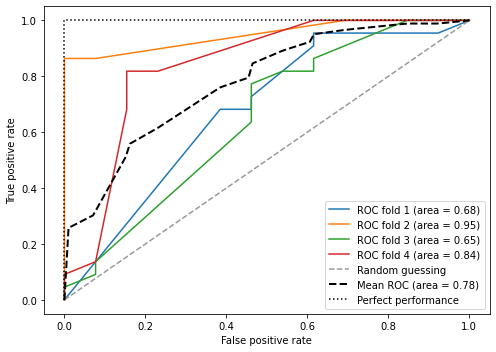

In [1458]:
from sklearn.metrics import roc_curve, auc
from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version


if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=0,
                                           C=100.0))

X_train2 = X_train[:, [1, 9]]
    
cv = list(StratifiedKFold(n_splits=4).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)
plt.show()

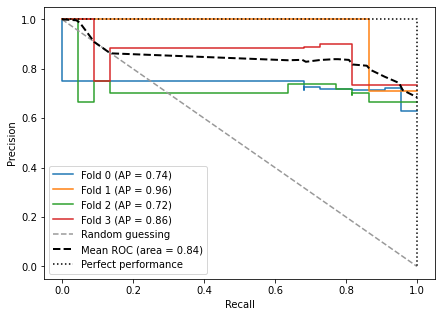

In [1459]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=(7, 5))

mean_precision = 0.0
mean_recall = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    pr_disp = plot_precision_recall_curve(
        pipe_lr, X_train2[test], y_train[test], 
        name=f'Fold {i}', ax=ax)
    mean_precision += interp(mean_recall, pr_disp.recall[::-1], 
                             pr_disp.precision[::-1])

plt.plot([0, 1], [1, 0],
         linestyle='--', color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_precision /= len(cv)
mean_auc = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 1, 1], [1, 1, 0],
         linestyle=':', color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
# plt.savefig('images/06_plot_precision_recall_curve.png', dpi=300)
plt.show()

In [1463]:
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')

In [1460]:
#불균형한 클래스 다루기

In [1470]:
X_imb = np.vstack((X[y == 0], X[y == 1][:20]))
y_imb = np.hstack((y[y == 0], y[y == 1][:20]))

In [1471]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

78.94736842105263

In [1472]:
#이번 프로젝트에서는 누가 승리하고 실패하는지에 대한 구분을 하는 것이므로 "재현율" 지표를 선택할 것 

In [1473]:
from sklearn.utils import resample

In [1474]:
from sklearn.utils import resample

print('샘플링하기 전 클래스 1의 샘플 개수:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('샘플링하기 후 클래스 1의 샘플 개수:', X_upsampled.shape[0])

샘플링하기 전 클래스 1의 샘플 개수: 20
샘플링하기 후 클래스 1의 샘플 개수: 75


In [1475]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [1476]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

### 앙상블

In [1478]:
#from scipy.stats import binom
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [1497]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """다수결 투표 앙상블 분류기

    매개변수
    ----------
    classifiers : 배열 타입, 크기 = [n_classifiers]
        앙상블에 사용할 분류기
    
    vote : str, {'classlabel', 'probability'}
        기본값: 'classlabel'
        'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됩니다
        'probability'면 확률 합이 가장 큰 인덱스로
        클래스 레이블을 예측합니다(보정된 분류기에 추천합니다)
    
    weights : 배열 타입, 크기 = [n_classifiers]
        선택 사항, 기본값: None
        'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치됩니다
        'weights=None'이면 동일하게 취급합니다

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """분류기를 학습합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            훈련 샘플 행렬
        
        y : 배열 타입, 크기 = [n_samples]
            타깃 클래스 레이블 벡터
            
        반환값
        -------
        self : 객체
        
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다"
                             "; (vote=%r)이 입력되었습니다."
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('분류기와 가중치 개수는 같아야 합니다'
                             '; 가중치 %d 개, 분류기 %d 개'
                             % (len(self.weights), len(self.classifiers)))

        # self.predict 메서드에서 np.argmax를 호출할 때
        # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용합니다
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """X에 대한 클래스 레이블을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            샘플 데이터 행렬
        
        반환값
        ----------
        maj_vote : 배열 타입, 크기 = [n_samples]
            예측된 클래스 레이블
        
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' 투표

            # clf.predict 메서드를 사용하여 결과를 모읍니다
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """X에 대한 클래스 확률을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            n_samples는 샘플의 개수고 n_features는 특성의 개수인
            샘플 데이터 행렬
        
        반환값
        ----------
        avg_proba : 배열 타입,
            크기 = [n_samples, n_classes]
            샘플마다 가중치가 적용된 클래스의 평균 확률
        
        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """GridSearch를 위해 분류기의 매개변수 이름을 반환합니다"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out


In [1484]:
masterMachine

,Ranked,gameDuration,level,lastRound,ingameDuration,itemC,championC,subDuration,level1,level2,level3
0,False,2142.470703,8,35,2134.272217,8,8,8.198486,1,3,4
1,False,2142.470703,9,35,2134.272217,12,9,8.198486,2,7,0
2,False,2142.470703,8,34,2073.459229,10,8,69.011475,1,6,1
3,True,2142.470703,8,33,1998.146729,10,8,144.323975,2,6,0
4,True,2142.470703,9,33,1986.443237,9,9,156.027466,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...
195,True,2197.485352,8,34,1972.834595,10,8,224.650757,1,6,1
196,True,2197.485352,8,31,1794.755371,8,8,402.729980,3,5,0
197,True,2197.485352,8,30,1730.138550,8,8,467.346802,1,7,0
198,True,2197.485352,8,27,1569.026489,5,8,628.458862,5,3,0


In [1870]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X, y = masterMachine.iloc[100:, [3,7]], masterMachine.iloc[100:, 0]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.3, 
                        random_state=0,
                        stratify=y)

In [1871]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-겹 교차 검증:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-겹 교차 검증:

ROC AUC: 1.00 (+/- 0.00) [Logistic regression]
ROC AUC: 0.98 (+/- 0.04) [Decision tree]
ROC AUC: 0.93 (+/- 0.09) [KNN]


In [1872]:
# 다수결 (하드) 투표

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 1.00 (+/- 0.00) [Logistic regression]
ROC AUC: 0.98 (+/- 0.04) [Decision tree]
ROC AUC: 0.93 (+/- 0.09) [KNN]
ROC AUC: 1.00 (+/- 0.00) [Majority voting]


In [1873]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[
    ('lr', pipe1), ('dt', clf2), ('knn', pipe3)], voting='soft')

scores = cross_validate(estimator=vc, X=X_train, y=y_train, 
                        cv=10, scoring='roc_auc')
print("ROC AUC: : %0.2f (+/- %0.2f) [%s]"
      % (scores['test_score'].mean(), 
         scores['test_score'].std(), 'VotingClassifier'))

ROC AUC: : 1.00 (+/- 0.00) [VotingClassifier]


In [1874]:
vc.set_params(verbose=True)

vc = vc.fit(X_train, y_train)

[Voting] ....................... (1 of 3) Processing lr, total=   0.0s
[Voting] ....................... (2 of 3) Processing dt, total=   0.0s
[Voting] ...................... (3 of 3) Processing knn, total=   0.0s


In [1875]:
### 앙상블 분류기와 평가 

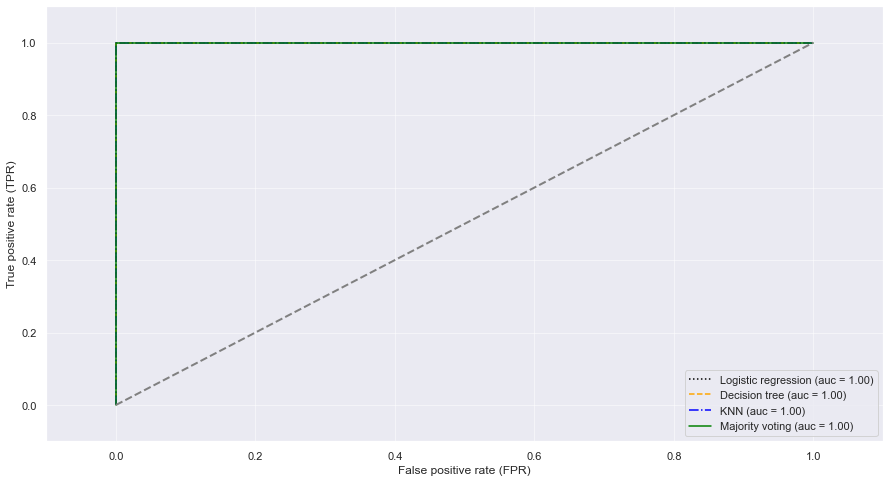

In [1876]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # 성공(승리)의 레이블이 1이라고 가정
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


# plt.savefig('images/07_04', dpi=300)
plt.show()

In [1877]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

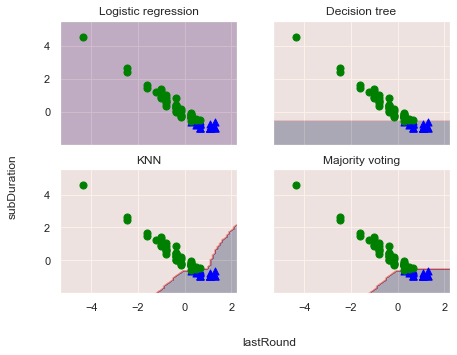

In [1885]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-5.5, -5., 
         s='lastRound', 
         ha='center', va='center', fontsize=12)
plt.text(-16.5, 4.5, 
         s='subDuration', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

# plt.savefig('images/07_05', dpi=300)
plt.show()

In [1886]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [1887]:
from sklearn.model_selection import GridSearchCV


params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [1888]:
print('최적의 매개변수: %s' % grid.best_params_)
print('정확도: %.2f' % grid.best_score_)

최적의 매개변수: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
정확도: 1.00


In [1889]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators=[
    ('lr', pipe1), ('dt', clf2), ('knn', pipe3)],
                           final_estimator=LogisticRegression())

params = {'dt__max_depth': [1, 2],
          'lr__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=stack,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

1.000 +/- 0.00 {'dt__max_depth': 1, 'lr__clf__C': 0.001}
1.000 +/- 0.00 {'dt__max_depth': 1, 'lr__clf__C': 0.1}
1.000 +/- 0.00 {'dt__max_depth': 1, 'lr__clf__C': 100.0}
1.000 +/- 0.00 {'dt__max_depth': 2, 'lr__clf__C': 0.001}
1.000 +/- 0.00 {'dt__max_depth': 2, 'lr__clf__C': 0.1}
1.000 +/- 0.00 {'dt__max_depth': 2, 'lr__clf__C': 100.0}


In [1890]:
print('최적의 매개변수: %s' % grid.best_params_)
print('정확도: %.2f' % grid.best_score_)

최적의 매개변수: {'dt__max_depth': 1, 'lr__clf__C': 0.001}
정확도: 1.00


In [1891]:
#배깅

In [1892]:
masterMachine

,Ranked,gameDuration,level,lastRound,ingameDuration,itemC,championC,subDuration,level1,level2,level3
0,1,2233.449951,8,37,2225.243408,10,8,8.206543,1,3,4
1,1,2233.449951,9,37,2225.243408,9,9,8.206543,2,7,0
2,1,2233.449951,8,35,2138.763428,7,8,94.686523,1,7,0
3,2,2233.449951,8,33,2003.865967,8,8,229.583984,0,8,0
4,2,2233.449951,7,31,1885.395386,7,7,348.054565,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...
195,2,2096.310791,8,33,1958.961548,11,8,137.349243,1,7,0
196,2,2096.310791,8,31,1846.332642,7,8,249.978149,2,6,0
197,2,2096.310791,8,31,1839.460449,5,7,256.850342,2,5,0
198,2,2096.310791,9,30,1767.110596,6,9,329.200195,5,4,0


In [1893]:
y = masterMachine['Ranked'].values
X = masterMachine[['lastRound', 'subDuration']].values

In [1894]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.3, 
                             random_state=0,
                             stratify=y)

In [1895]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=0)

In [1896]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (bag_train, bag_test))

결정 트리의 훈련 정확도/테스트 정확도 1.000/0.950
배깅의 훈련 정확도/테스트 정확도 1.000/0.950


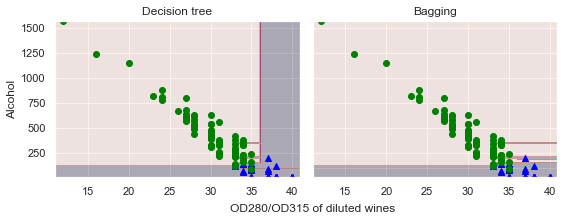

In [1897]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

# plt.savefig('images/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

In [1898]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(oob_score=True,
                            random_state=1)
rf.fit(X_train, y_train)

rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)
print('랜덤 포레스트의 훈련 정확도/테스트 정확도 %.3f/%.3f' % 
      (rf_train_score, rf_test_score))
print('랜덤 포레스트의 OOB 정확도 %.3f' % rf.oob_score_)

랜덤 포레스트의 훈련 정확도/테스트 정확도 1.000/0.950
랜덤 포레스트의 OOB 정확도 0.929


In [1899]:
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        oob_score=True,
                        random_state=1)
bag.fit(X_train, y_train)

bag_train_score = bag.score(X_train, y_train)
bag_test_score = bag.score(X_test, y_test)
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f' % 
      (bag_train_score, bag_test_score))
print('배깅의 OOB 정확도 %.3f' % bag.oob_score_)

배깅의 훈련 정확도/테스트 정확도 1.000/0.950
배깅의 OOB 정확도 0.936


In [1900]:
#에이다 부스트 

In [1901]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=0)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=0)

In [1902]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('에이다부스트의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (ada_train, ada_test))

결정 트리의 훈련 정확도/테스트 정확도 0.950/0.950
에이다부스트의 훈련 정확도/테스트 정확도 1.000/0.967


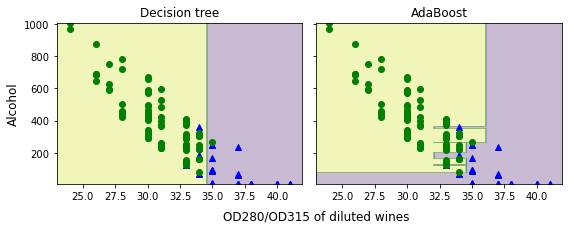

In [1564]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

# plt.savefig('images/07_11.png', dpi=300, bbox_inches='tight')
plt.show()

In [1903]:
#그래디언트 부스팅

In [1904]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(n_estimators=20, random_state=42)
gbrt.fit(X_train, y_train)

gbrt_train_score = gbrt.score(X_train, y_train)
gbrt_test_score = gbrt.score(X_test, y_test)
print('그래디언트 부스팅의 훈련 정확도/테스트 정확도 %.3f/%.3f' 
      % (gbrt_train_score, gbrt_test_score))

그래디언트 부스팅의 훈련 정확도/테스트 정확도 0.979/0.967


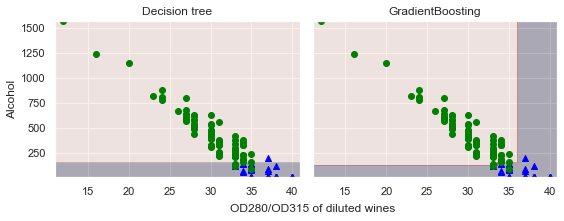

In [1905]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, gbrt],
                        ['Decision tree', 'GradientBoosting']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12,
         transform=axarr[1].transAxes)

# plt.savefig('images/07_gradientboosting.png', dpi=300, bbox_inches='tight')
plt.show()


Text(0, 0.5, 'loss')

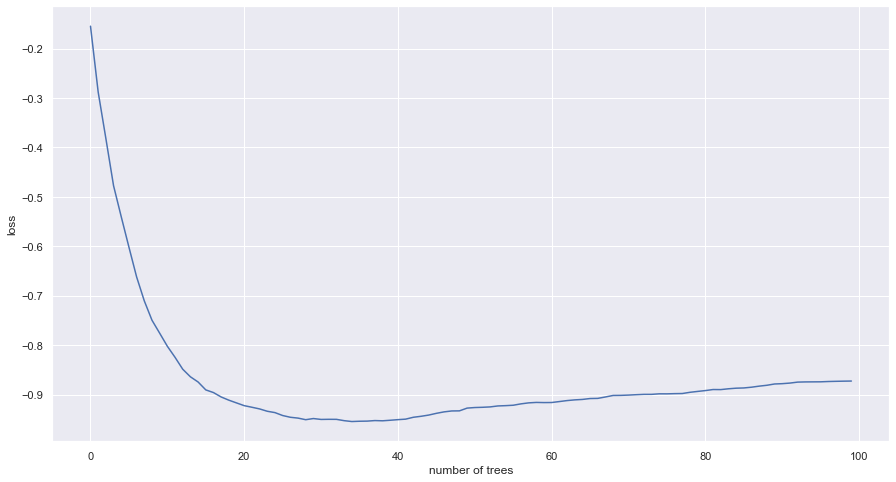

In [1906]:
gbrt = GradientBoostingClassifier(n_estimators=100, 
                                  subsample=0.5,
                                  random_state=1)
gbrt.fit(X_train, y_train)
oob_loss = np.cumsum(-gbrt.oob_improvement_)
plt.plot(range(100), oob_loss)
plt.xlabel('number of trees')
plt.ylabel('loss')

#plt.show()

In [1574]:
!pip install xgboost 

You should consider upgrading via the 'c:\users\dajin\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1575]:
# 히스토그램 기반 부스팅 
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist', eval_metric='logloss', use_label_encoder=False, random_state=1)
xgb.fit(X_train, y_train)

xgb_train_score = xgb.score(X_train, y_train)
xgb_test_score = xgb.score(X_test, y_test)

print('XGBoost 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (xgb_train_score, xgb_test_score))

XGBoost 훈련 정확도/테스트 정확도 0.986/0.933


In [1577]:
!pip install lightgbm

You should consider upgrading via the 'c:\users\dajin\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1578]:
# lightgbm
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=1)
lgb.fit(X_train, y_train)

lgb_train_score = lgb.score(X_train, y_train)
lgb_test_score = lgb.score(X_test, y_test)

print('LightGBM 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (lgb_train_score, lgb_test_score))

LightGBM 훈련 정확도/테스트 정확도 0.979/0.917


### 다중 선형 회귀분석 

In [1579]:
masterMachine.head()

,Ranked,gameDuration,level,lastRound,ingameDuration,itemC,championC,subDuration,level1,level2,level3
0,False,2142.470703,8,35,2134.272217,8,8,8.198486,1,3,4
1,False,2142.470703,9,35,2134.272217,12,9,8.198486,2,7,0
2,False,2142.470703,8,34,2073.459229,10,8,69.011475,1,6,1
3,True,2142.470703,8,33,1998.146729,10,8,144.323975,2,6,0
4,True,2142.470703,9,33,1986.443237,9,9,156.027466,5,4,0


In [1580]:
#탐색적 데이터 분석 

In [1581]:
#(1)산점도 행렬

In [1585]:
!pip install mlxtend

You should consider upgrading via the 'c:\users\dajin\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1586]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

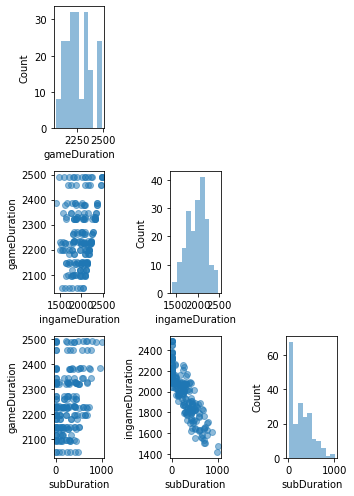

In [1592]:
cols = ['gameDuration','ingameDuration','subDuration'] 
scatterplotmatrix(masterMachine[cols].values, figsize=(5,7),
                 names =cols, alpha = 0.5)
plt.tight_layout()
plt.show()

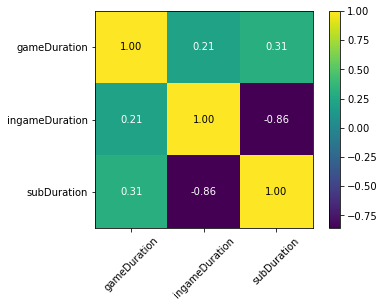

In [1595]:
import numpy as np
from mlxtend.plotting import heatmap


cm = np.corrcoef(masterMachine[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)

# plt.savefig('images/10_04.png', dpi=300)
plt.show()

1. subDuration과 Ranked

In [1907]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [1920]:
X = masterMachine[['subDuration']].values
y = masterMachine['Ranked'].values

In [1921]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [1922]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

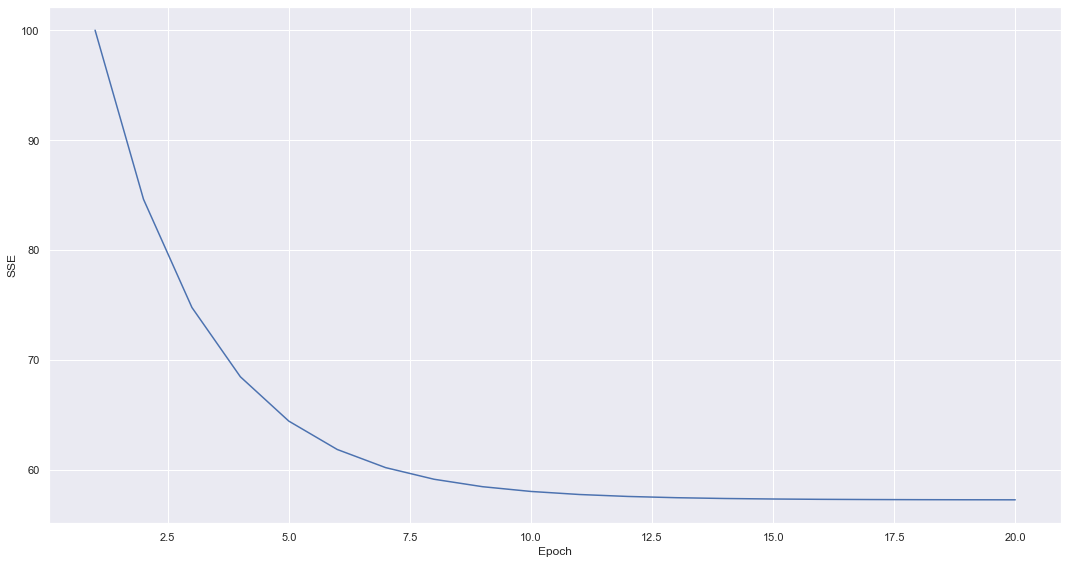

In [1923]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.tight_layout()
# plt.savefig('images/10_05.png', dpi=300)
plt.show()

In [1924]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return

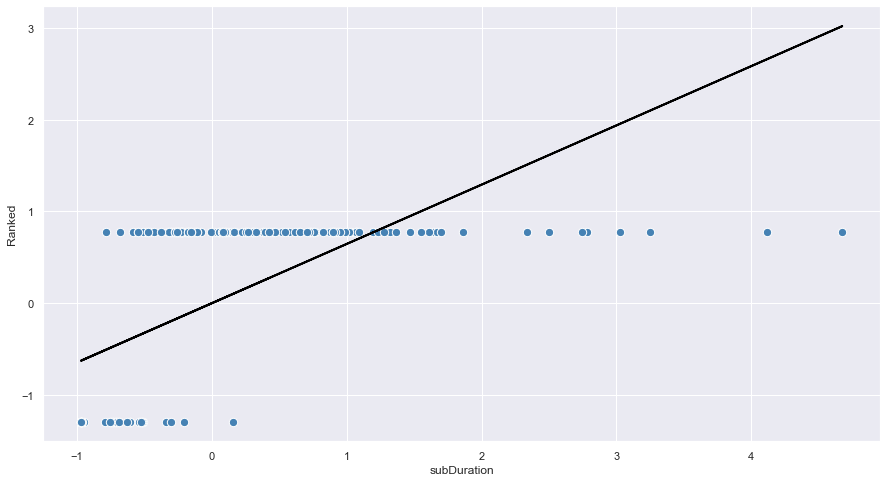

In [1925]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('subDuration')
plt.ylabel('Ranked')

# plt.savefig('images/10_06.png', dpi=300)
plt.show()

2. Ranked와 lastRound

In [1926]:
X = masterMachine[['lastRound']].values
y = masterMachine['Ranked'].values

In [1927]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [1928]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

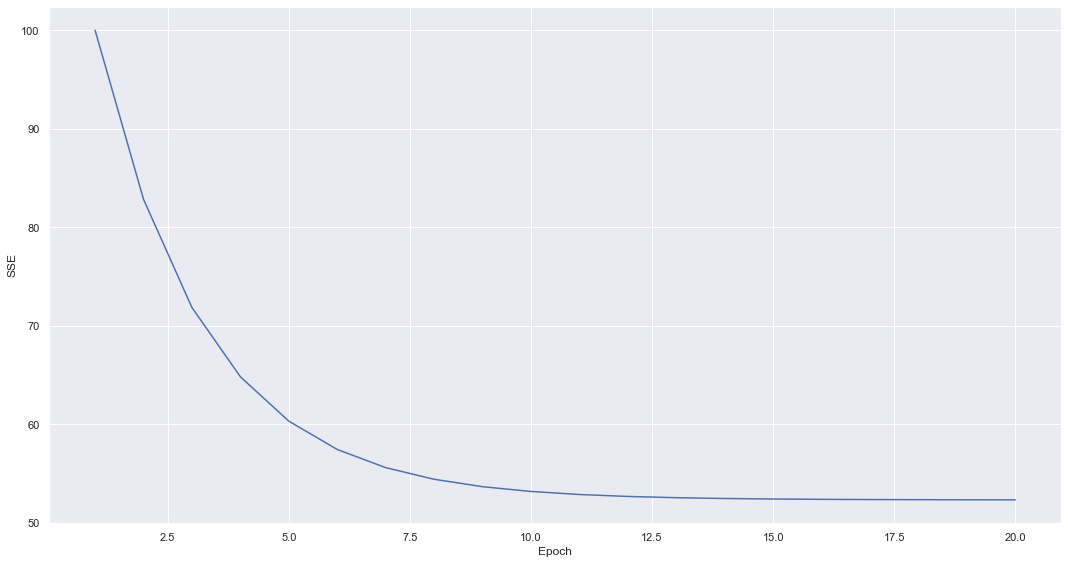

In [1929]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.tight_layout()
# plt.savefig('images/10_05.png', dpi=300)
plt.show()

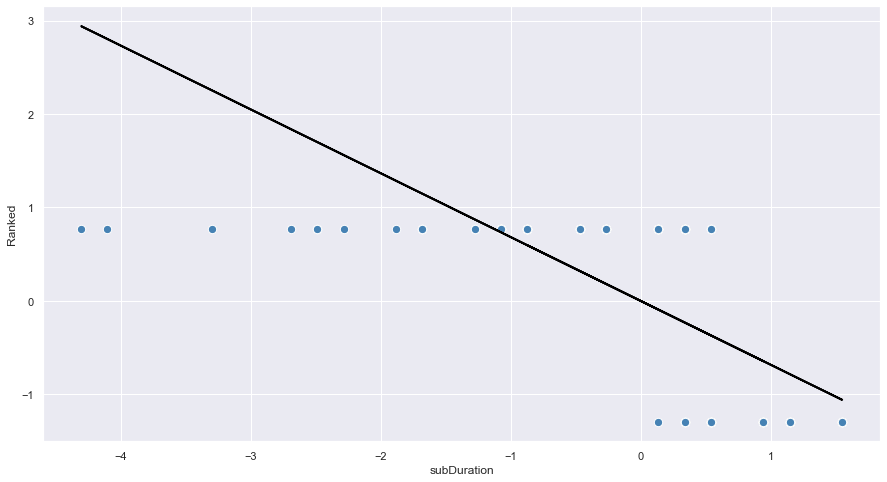

In [1930]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('subDuration')
plt.ylabel('Ranked')

# plt.savefig('images/10_06.png', dpi=300)
plt.show()

3. lastRound와 subDuration

In [1931]:
X = masterMachine[['lastRound']].values
y = masterMachine['subDuration'].values

In [1932]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [1933]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

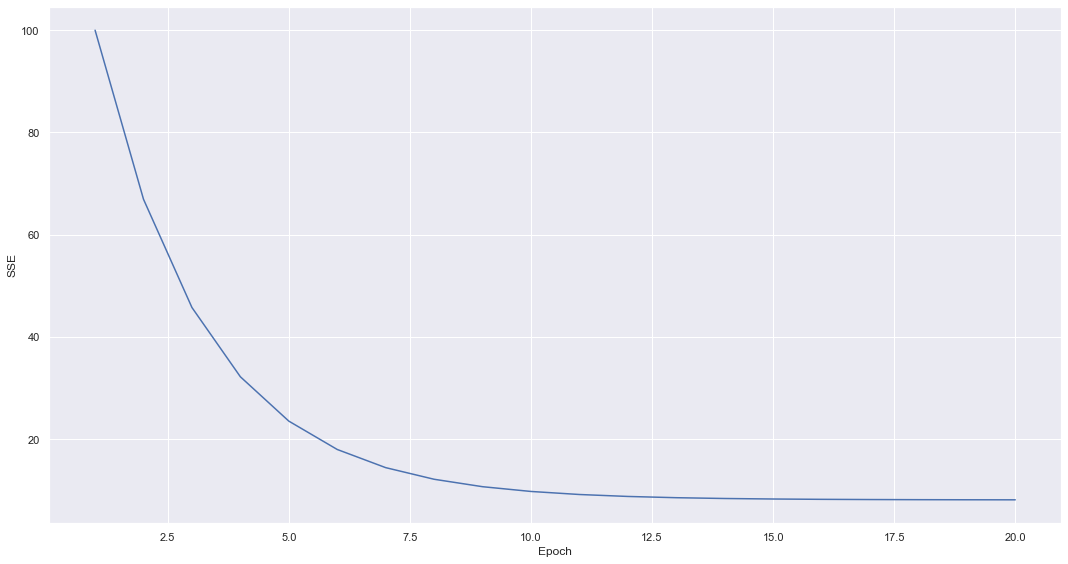

In [1934]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.tight_layout()
# plt.savefig('images/10_05.png', dpi=300)
plt.show()

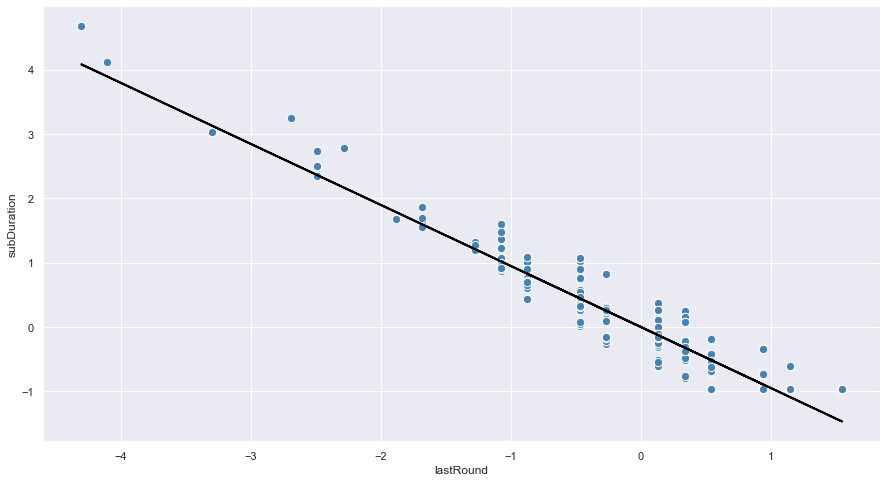

In [1937]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('lastRound')
plt.ylabel('subDuration')

# plt.savefig('images/10_06.png', dpi=300)
plt.show()

In [1936]:
print('기울기: %.3f' % lr.w_[1])
print('절편: %.3f' % lr.w_[0])

기울기: -0.948
절편: 0.000


In [1940]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("라운드 5개당: %.3f분의 차이가 난다고 할 수 있다! " % sc_y.inverse_transform(price_std.reshape(-1,1)))

라운드 5개당: 1907.071분의 차이가 난다고 할 수 있다! 


- 11/09일까지의 데이터 분석과 시각화, 머신러닝 기법들의 사용을 보았을 때
 
1. Ranked의 승리 예측 요소는 선형적(= 독립 변수 1개, 종속변수1개)로만 이루어지는 것은 오류가 크고, 정확성에 대한 부분에서 보이지 않는 오류가 있음을 나타냄 
    - 예로 재현율, 정확성이 높지만, 실질적으로 랭크와 게임 시간 길이만으로 넣었을 때 예측 실패의 요인이 존재함
2. 총게임시간, 유저가 한 게임 시간, 총 게임 - 유저한 게임시간(SubDuration)에서 SubDuration의 요인이 랭크에 제일 많이 연관성이 있음

3. 랜덤 포레스트로 얻은 1) subDuration  2) ingameDuration  3) lastRound 에서 1)과 2) 공산성, 1)과 3)의 공산성 높으며 그 중 subDuration, lastRound이 포함된 다중 회귀분석 또한 필요하다고 생각했음 


________________________________________________________________________________________________________________________________________

- 최종 발표에서 필요한 기법과 방향성 선택

1. 랜덤 포레스트와 그래디언드 부스팅, XG부스팅 등의 기본적인 머신러닝 기법과 다중 회귀 분석을 포함한 분석 실행
2. 승률 예측을 위한 시너지와 챔피언의 요소 원-핫 인코딩과 딥러닝 기법을 사용하여 학습-테스트 모델 마침 
3. input 열을 넣고 output (승리, 실패)의 결과 수립 

# ------------------------------------deep learning component--------------------------------------

In [451]:
col.values()

dict_values([{'items': [], 'star': 2}, {'items': [], 'star': 2}, {'items': [], 'star': 2}, {'items': [], 'star': 2}, {'items': [22, 57, 1], 'star': 1}, {'items': [], 'star': 1}, {'items': [15, 33, 36], 'star': 1}, {'items': [44, 4], 'star': 1}])

In [452]:
print(item)

None


In [453]:
masterData.champion

0      {'JarvanIV': 3, 'Sona': 3, 'Rakan': 3, 'XinZha...
1      {'JarvanIV': 0, 'Sona': 2, 'Rakan': 0, 'XinZha...
2      {'JarvanIV': 0, 'Sona': 0, 'Rakan': 0, 'XinZha...
3      {'JarvanIV': 0, 'Sona': 0, 'Rakan': 0, 'XinZha...
4      {'JarvanIV': 0, 'Sona': 1, 'Rakan': 0, 'XinZha...
                             ...                        
195    {'JarvanIV': 0, 'Sona': 0, 'Rakan': 0, 'XinZha...
196    {'JarvanIV': 0, 'Sona': 1, 'Rakan': 0, 'XinZha...
197    {'JarvanIV': 0, 'Sona': 0, 'Rakan': 0, 'XinZha...
198    {'JarvanIV': 0, 'Sona': 0, 'Rakan': 0, 'XinZha...
199    {'JarvanIV': 0, 'Sona': 2, 'Rakan': 0, 'XinZha...
Name: champion, Length: 200, dtype: object

In [454]:
for c in champion_col:
    for i in range(len(masterData)):
        masterData.loc[i,c] = masterData.loc[i, 'champion'][c]

In [630]:
masterData.head(5)

,gameId,gameDuration,level,lastRound,Ranked,ingameDuration,combination,champion,DarkStar,Protector,...,Irelia,Xayah,Kassadin,Thresh,Ahri,Syndra,Zoe,VelKoz,Shen,Darius
0,KR_4247538593,2142.470703,8,35,1,2134.272217,"{'DarkStar': 2, 'Protector': 4, 'Rebel': 1, 'S...","{'JarvanIV': 3, 'Sona': 3, 'Rakan': 3, 'XinZha...",2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KR_4247538593,2142.470703,9,35,2,2134.272217,"{'DarkStar': 0, 'Protector': 0, 'Rebel': 6, 'S...","{'JarvanIV': 0, 'Sona': 2, 'Rakan': 0, 'XinZha...",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,KR_4247538593,2142.470703,8,34,3,2073.459229,"{'DarkStar': 3, 'Protector': 0, 'Rebel': 0, 'S...","{'JarvanIV': 0, 'Sona': 0, 'Rakan': 0, 'XinZha...",3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KR_4247538593,2142.470703,8,33,4,1998.146729,"{'DarkStar': 1, 'Protector': 0, 'Rebel': 0, 'S...","{'JarvanIV': 0, 'Sona': 0, 'Rakan': 0, 'XinZha...",1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,KR_4247538593,2142.470703,9,33,5,1986.443237,"{'DarkStar': 0, 'Protector': 0, 'Rebel': 6, 'S...","{'JarvanIV': 0, 'Sona': 1, 'Rakan': 0, 'XinZha...",0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [631]:
# 1-8등의 경우로 했을 때 잘못 분류된 샘플의 갯수가 많아 
# 기준을 달리 함 
# set1 : 1-4, 4,8
# set2 : 1-2, 3-4, 5-6, 7-8
tft_data.Ranked = tft_data.Ranked >= 4

In [590]:
tft_data = masterData.drop(columns = ['gameId','combination','champion','lastRound'], axis =1)

In [591]:
tft_label = (tft_data['Ranked'])

In [632]:
tft_data

,gameDuration,level,Ranked,ingameDuration,DarkStar,Protector,Rebel,Set3_Celestial,Set3_Mystic,StarGuardian,...,Irelia,Xayah,Kassadin,Thresh,Ahri,Syndra,Zoe,VelKoz,Shen,Darius
0,2142.470703,8,False,2134.272217,2.0,4.0,1.0,3.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2142.470703,9,False,2134.272217,0.0,0.0,6.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2142.470703,8,False,2073.459229,3.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2142.470703,8,True,1998.146729,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2142.470703,9,True,1986.443237,0.0,0.0,6.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2197.485352,8,True,1972.834595,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,2197.485352,8,True,1794.755371,0.0,0.0,6.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,2197.485352,8,True,1730.138550,3.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,2197.485352,8,True,1569.026489,0.0,0.0,1.0,0.0,0.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<AxesSubplot:>

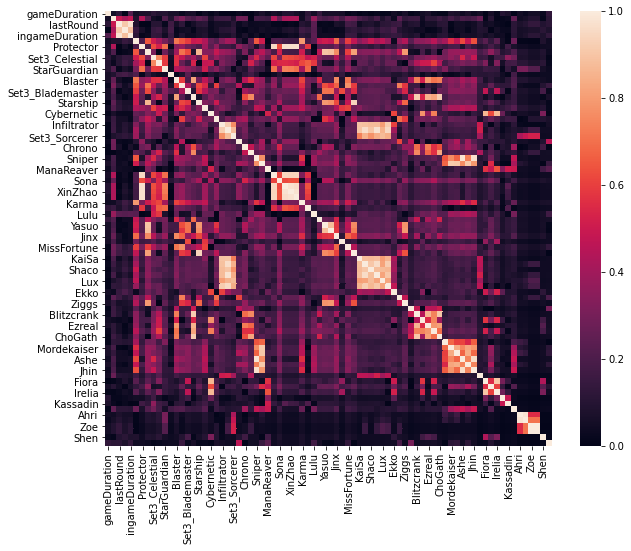

In [633]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(masterData.corr().abs())

In [594]:
# 테스트 모델과 학습 모델 나누기 

In [634]:
tft_data.loc[:,tft_data.columns != 'Ranked']

,gameDuration,level,ingameDuration,DarkStar,Protector,Rebel,Set3_Celestial,Set3_Mystic,StarGuardian,TemplateTrait,...,Irelia,Xayah,Kassadin,Thresh,Ahri,Syndra,Zoe,VelKoz,Shen,Darius
0,2142.470703,8,2134.272217,2.0,4.0,1.0,3.0,4.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2142.470703,9,2134.272217,0.0,0.0,6.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2142.470703,8,2073.459229,3.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2142.470703,8,1998.146729,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2142.470703,9,1986.443237,0.0,0.0,6.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2197.485352,8,1972.834595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,2197.485352,8,1794.755371,0.0,0.0,6.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,2197.485352,8,1730.138550,3.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,2197.485352,8,1569.026489,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [686]:
#option1
#X, y = tft_data.iloc[:,4:].values, tft_data.iloc[:,2].values
#option2
X, y = tft_data.loc[:,tft_data.columns != 'Ranked'].values, tft_data.iloc[:,2].values
#optionN-1
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=1, stratify = y)
#optionN-2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=0)

In [687]:
print('y의 레이블 카운트 :' ,np.bincount(y))

y의 레이블 카운트 : [ 75 125]


In [688]:
print('y_train의 레이블 카운트 :' ,np.bincount(y_train))

y_train의 레이블 카운트 : [47 93]


In [689]:
print('y_train의 레이블 카운트 :' ,np.bincount(y_test))

y_train의 레이블 카운트 : [28 32]


In [690]:
#특성케일 조정 2- 표준화 

In [691]:
from sklearn.preprocessing import StandardScaler

In [692]:
sc =  StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [693]:
#퍼셉트론 모델 훈련

In [694]:
from sklearn.linear_model import Perceptron

In [695]:
ppn = Perceptron(eta0 =0.1, random_state =0)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1)

In [696]:
y_pred = ppn.predict(X_test_std)
print('잘못 분류된 샘플 개수 : %d' %(y_test != y_pred).sum())

잘못 분류된 샘플 개수 : 7


In [697]:
#정확도 
from sklearn.metrics import accuracy_score

In [698]:
print('정확도 : %.3f' %accuracy_score(y_test, y_pred))

정확도 : 0.883


In [699]:
print('정확도: %.3f' %ppn.score(X_test_std, y_test))

정확도: 0.883
